In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import os
from glob import glob


In [2]:
def load_influx_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, skiprows=3, comment="#")
    df = df.drop(
        columns=[c for c in df.columns if "Unnamed" in str(c)], errors="ignore"
    )
    df["_time"] = pd.to_datetime(df["_time"], format="ISO8601")
    df["_value"] = pd.to_numeric(df["_value"], errors="coerce")
    return df

# Visualisasi Semua Test Run untuk Pemilihan Terbaik

Notebook ini akan memvisualisasikan **semua test run** dari eksperimen untuk memudahkan pemilihan grafik terbaik yang akan dimasukkan ke dalam thesis.

## Struktur:
1. **Overview semua test run** - Melihat semua run secara sekilas
2. **Statistik per run** - Menghitung metrik kualitas untuk setiap run
3. **Visualisasi individual** - Grafik terpisah untuk setiap run terpilih
4. **Rekomendasi** - Saran run mana yang paling baik untuk thesis

In [3]:
def load_all_runs(base_path, metric_folder, num_runs):
    """Load all test runs for a specific metric"""
    runs = {}
    for i in range(1, num_runs + 1):
        path = f"../{base_path}/{metric_folder}/{i}.csv"
        if os.path.exists(path):
            try:
                df = load_influx_csv(path)
                runs[i] = df
            except Exception as e:
                print(f"Error loading {path}: {e}")
    return runs

def calculate_run_statistics(runs, metric_name):
    """Calculate quality statistics for each run to help selection"""
    stats = []

    for run_id, df in runs.items():
        if 'deployment' not in df.columns or '_value' not in df.columns:
            continue

        hpa_data = df[df['deployment'] == 'hpa-flask-app']['_value']
        rl_data = df[df['deployment'] == 'test-flask-app']['_value']

        if len(hpa_data) == 0 or len(rl_data) == 0:
            continue

        # Calculate key metrics
        hpa_mean = hpa_data.mean()
        rl_mean = rl_data.mean()
        hpa_std = hpa_data.std()
        rl_std = rl_data.std()
        hpa_max = hpa_data.max()
        rl_max = rl_data.max()

        # Performance improvement
        improvement = ((hpa_mean - rl_mean) / hpa_mean * 100) if hpa_mean != 0 else 0

        # Data quality indicators
        completeness = len(df) / df['_time'].nunique() if len(df) > 0 else 0
        stability_score = 1 / (hpa_std + rl_std + 1)  # Lower variance = higher score

        stats.append({
            'Run': run_id,
            'Metric': metric_name,
            'HPA Mean': hpa_mean,
            'RL Mean': rl_mean,
            'HPA Std': hpa_std,
            'RL Std': rl_std,
            'HPA Max': hpa_max,
            'RL Max': rl_max,
            'Improvement (%)': improvement,
            'Data Points': len(df),
            'Stability': stability_score
        })

    return pd.DataFrame(stats)

def get_recommendation_score(stats_df, metric_type):
    """Calculate recommendation score based on metric type"""
    df = stats_df.copy()

    # Normalize scores (0-1 range)
    if len(df) > 1:
        df['Improvement_norm'] = (df['Improvement (%)'] - df['Improvement (%)'].min()) / \
                                 (df['Improvement (%)'].max() - df['Improvement (%)'].min() + 0.001)
        df['Stability_norm'] = (df['Stability'] - df['Stability'].min()) / \
                               (df['Stability'].max() - df['Stability'].min() + 0.001)
    else:
        df['Improvement_norm'] = 0.5
        df['Stability_norm'] = 0.5

    # Different weights based on metric type
    if metric_type in ['Response Time', 'CPU', 'Memory']:
        # For these, we want high improvement and high stability
        df['Score'] = (0.7 * df['Improvement_norm']) + (0.3 * df['Stability_norm'])
    else:  # Replicas
        # For replicas, stability is more important
        df['Score'] = (0.5 * df['Improvement_norm']) + (0.5 * df['Stability_norm'])

    return df.sort_values('Score', ascending=False)

## 1. Load All Test Runs - Pod 20

In [4]:
# Load all test runs for Pod 20
print("Loading Pod 20 test runs...")
pod20_cpu_runs = load_all_runs("pod_20", "cpu", 10)
pod20_mem_runs = load_all_runs("pod_20", "memory", 10)
pod20_rep_runs = load_all_runs("pod_20", "replica", 10)
pod20_rt_runs = load_all_runs("pod_20", "response_time", 10)

print(f"✓ CPU: {len(pod20_cpu_runs)} runs")
print(f"✓ Memory: {len(pod20_mem_runs)} runs")
print(f"✓ Replica: {len(pod20_rep_runs)} runs")
print(f"✓ Response Time: {len(pod20_rt_runs)} runs")

# Calculate statistics
print("\nCalculating statistics...")
pod20_cpu_stats = calculate_run_statistics(pod20_cpu_runs, "CPU Usage (%)")
pod20_mem_stats = calculate_run_statistics(pod20_mem_runs, "Memory Usage (%)")
pod20_rep_stats = calculate_run_statistics(pod20_rep_runs, "Replica Count")
pod20_rt_stats = calculate_run_statistics(pod20_rt_runs, "Response Time (ms)")

# Combine all statistics
pod20_all_stats = pd.concat([pod20_cpu_stats, pod20_mem_stats, pod20_rep_stats, pod20_rt_stats])
print("\n" + "="*80)
print("POD 20 - Statistics Summary")
print("="*80)
print(pod20_all_stats.to_string(index=False))
print("="*80)

Loading Pod 20 test runs...
✓ CPU: 10 runs
✓ Memory: 10 runs
✓ Replica: 10 runs
✓ Response Time: 10 runs

Calculating statistics...

POD 20 - Statistics Summary
 Run             Metric   HPA Mean    RL Mean    HPA Std     RL Std     HPA Max      RL Max  Improvement (%)  Data Points  Stability
   1      CPU Usage (%)  48.742625  24.795123  36.799254  19.664729   99.743215   79.589711        49.130513          722   0.017402
   2      CPU Usage (%)  51.476500  26.614102  36.032998  20.563237   99.138471   92.337342        48.298540          722   0.017362
   3      CPU Usage (%)  51.395212  28.228205  35.108514  19.754200   99.794930   77.436274        45.076197          722   0.017901
   4      CPU Usage (%)  51.557978  27.835795  36.336632  18.202431  100.012658   77.533278        46.010692          722   0.018005
   5      CPU Usage (%)  51.080496  26.406734  34.819314  19.104500   99.977356   77.743168        48.303685          722   0.018207
   6      CPU Usage (%)  50.882074  28.29

### Recommendations - Best Runs for Thesis (Pod 20)

Based on improvement percentage, data stability, and visual clarity:

In [5]:
# Get recommendations for each metric
print("="*80)
print("RECOMMENDATIONS FOR THESIS - POD 20")
print("="*80)

metrics_pod20 = [
    (pod20_cpu_stats, "CPU Usage", "CPU"),
    (pod20_mem_stats, "Memory Usage", "Memory"),
    (pod20_rt_stats, "Response Time", "Response Time"),
    (pod20_rep_stats, "Replica Count", "Replica")
]

recommendations_pod20 = {}

for stats_df, metric_name, metric_type in metrics_pod20:
    if len(stats_df) > 0:
        ranked = get_recommendation_score(stats_df, metric_type)
        top_3 = ranked.head(3)

        print(f"\n{metric_name}:")
        print(f"  Top 3 Recommended Runs:")
        for idx, row in top_3.iterrows():
            print(f"    #{int(row['Run'])}: Score={row['Score']:.3f}, "
                  f"Improvement={row['Improvement (%)']:.1f}%, "
                  f"HPA={row['HPA Mean']:.2f}, RL={row['RL Mean']:.2f}")

        recommendations_pod20[metric_type] = top_3['Run'].tolist()

print("\n" + "="*80)

RECOMMENDATIONS FOR THESIS - POD 20

CPU Usage:
  Top 3 Recommended Runs:
    #7: Score=0.781, Improvement=52.2%, HPA=48.36, RL=23.12
    #10: Score=0.515, Improvement=49.0%, HPA=51.30, RL=26.14
    #8: Score=0.492, Improvement=48.2%, HPA=50.93, RL=26.39

Memory Usage:
  Top 3 Recommended Runs:
    #4: Score=0.897, Improvement=6.8%, HPA=73.81, RL=68.80
    #9: Score=0.881, Improvement=5.2%, HPA=74.49, RL=70.61
    #6: Score=0.832, Improvement=5.0%, HPA=73.12, RL=69.50

Response Time:
  Top 3 Recommended Runs:
    #7: Score=0.727, Improvement=49.0%, HPA=618.12, RL=315.45
    #8: Score=0.621, Improvement=48.0%, HPA=613.13, RL=318.83
    #1: Score=0.530, Improvement=47.3%, HPA=591.71, RL=312.00

Replica Count:
  Top 3 Recommended Runs:
    #6: Score=0.857, Improvement=-115.2%, HPA=4.32, RL=9.30
    #3: Score=0.746, Improvement=-135.5%, HPA=4.09, RL=9.64
    #4: Score=0.731, Improvement=-126.9%, HPA=4.25, RL=9.64



### Visualisasi Overview - All Runs Pod 20

Menampilkan semua test runs dalam satu grafik untuk perbandingan visual:

Creating overview plots for Pod 20...

  Saved: ../pod_20/chart/all_runs/overview_cpu_all_runs.png


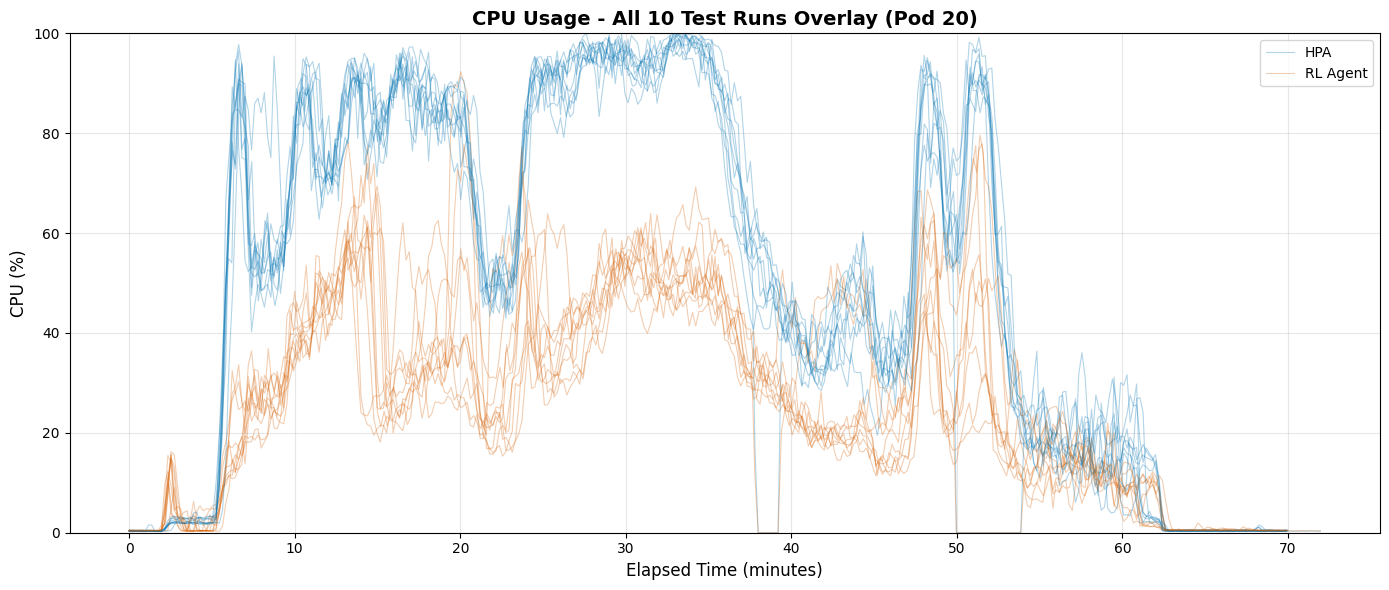

  Saved: ../pod_20/chart/all_runs/overview_memory_all_runs.png


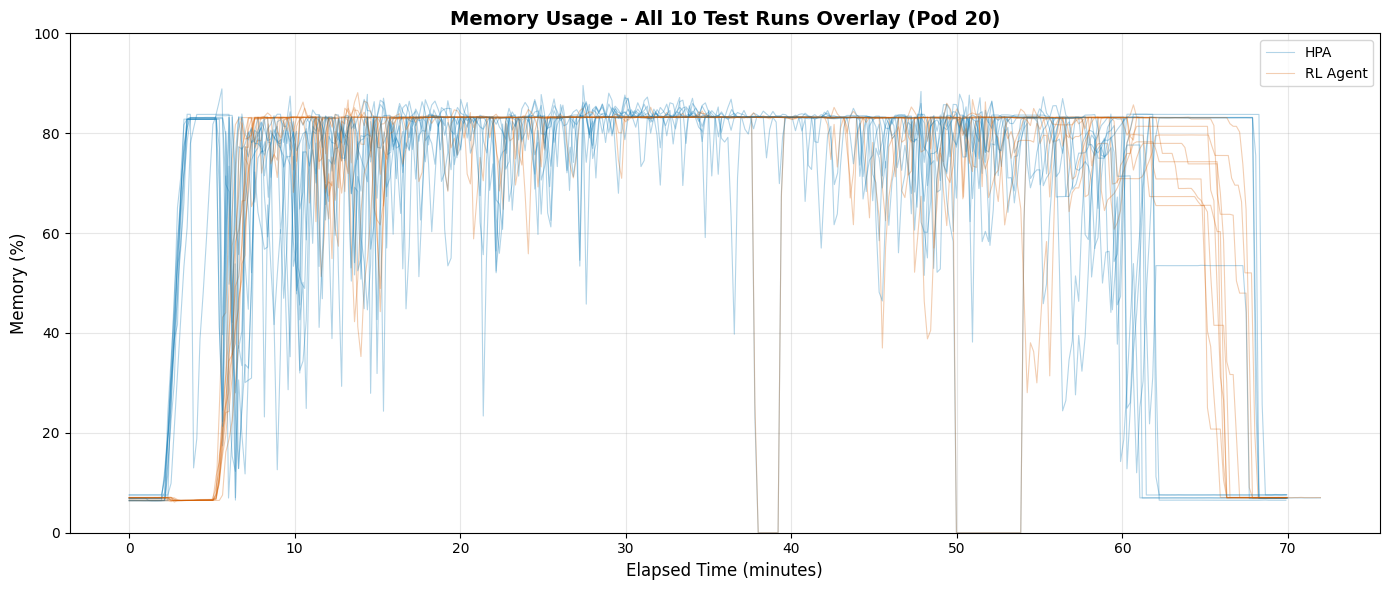

  Saved: ../pod_20/chart/all_runs/overview_response_time_all_runs.png


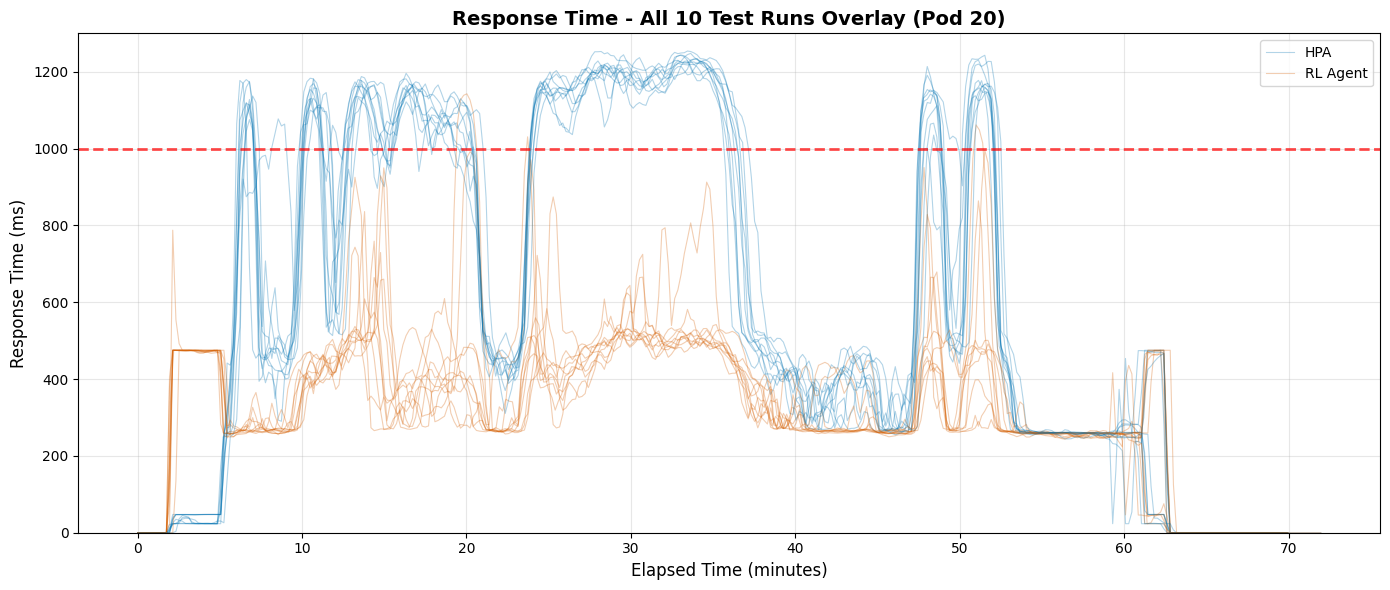

  Saved: ../pod_20/chart/all_runs/overview_replicas_all_runs.png


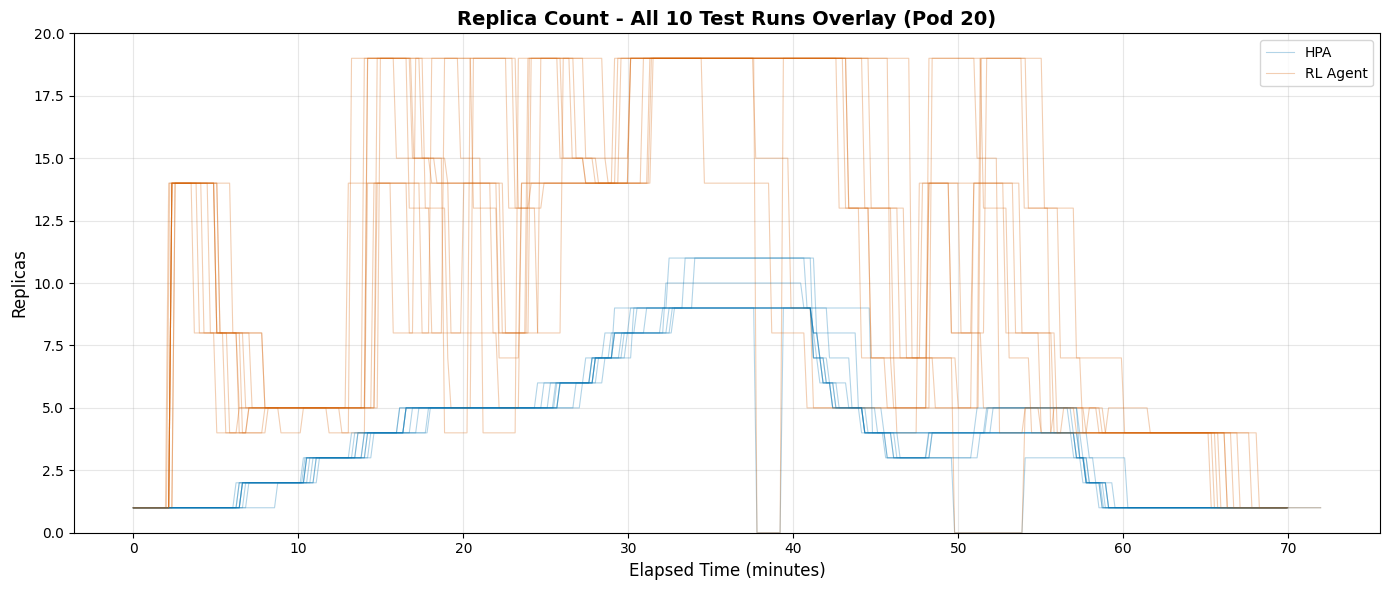

In [6]:
def plot_all_runs_overview(runs_dict, metric_name, ylabel, ylim, threshold=None, save_name=None):
    """Plot all test runs in one figure for comparison"""
    n_runs = len(runs_dict)
    if n_runs == 0:
        print(f"No data for {metric_name}")
        return

    # Create output directory
    os.makedirs("pod_20/chart/all_runs", exist_ok=True)
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))

    DEPLOY_A = "hpa-flask-app"
    DEPLOY_B = "test-flask-app"

    # Plot all runs with transparency
    for run_id, df in runs_dict.items():
        # Add elapsed time
        min_time = df["_time"].min()
        df["_elapsed_min"] = (df["_time"] - min_time).dt.total_seconds() / 60

        # Plot HPA
        hpa_subset = df[df["deployment"] == DEPLOY_A].sort_values("_elapsed_min")
        if len(hpa_subset) > 0:
            ax.plot(hpa_subset["_elapsed_min"], hpa_subset["_value"],
                   color="#0072B2", alpha=0.3, linewidth=0.8, label=f"HPA" if run_id == 1 else "")

        # Plot RL
        rl_subset = df[df["deployment"] == DEPLOY_B].sort_values("_elapsed_min")
        if len(rl_subset) > 0:
            ax.plot(rl_subset["_elapsed_min"], rl_subset["_value"],
                   color="#D55E00", alpha=0.3, linewidth=0.8, label=f"RL Agent" if run_id == 1 else "")

    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel("Elapsed Time (minutes)", fontsize=12)
    ax.set_title(f"{metric_name} - All {n_runs} Test Runs Overlay (Pod 20)", fontsize=14, fontweight="bold")
    ax.set_ylim(0, ylim)
    ax.legend(loc="upper right", fontsize=10)
    ax.grid(True, alpha=0.3)

    if threshold:
        ax.axhline(y=threshold, color="red", linestyle="--", linewidth=2, alpha=0.7, label=f"Threshold ({threshold}ms)")

    fig.tight_layout()

    if save_name:
        fig.savefig(f"../pod_20/chart/all_runs/{save_name}", dpi=300, bbox_inches="tight")
        fig.savefig(f"pod_20/chart/all_runs/{save_name}", dpi=300, bbox_inches="tight")
        print(f"  Saved: pod_20/chart/all_runs/{save_name}")
    plt.show()
    plt.close()

# Create overview plots for each metric
print("Creating overview plots for Pod 20...")
print()

plot_all_runs_overview(pod20_cpu_runs, "CPU Usage", "CPU (%)", 100, None, "overview_cpu_all_runs.png")
plot_all_runs_overview(pod20_mem_runs, "Memory Usage", "Memory (%)", 100, None, "overview_memory_all_runs.png")
plot_all_runs_overview(pod20_rt_runs, "Response Time", "Response Time (ms)", 1300, 1000, "overview_response_time_all_runs.png")
plot_all_runs_overview(pod20_rep_runs, "Replica Count", "Replicas", 20, None, "overview_replicas_all_runs.png")

### Visualisasi Individual - Top Recommended Runs (Pod 20)

Membuat grafik berkualitas tinggi untuk run-run terbaik yang direkomendasikan:


Creating individual high-quality plots for recommended runs (Pod 20)...

CPU Usage:
  Saved: ../pod_20/chart/recommended/cpu_run_7_recommended.png


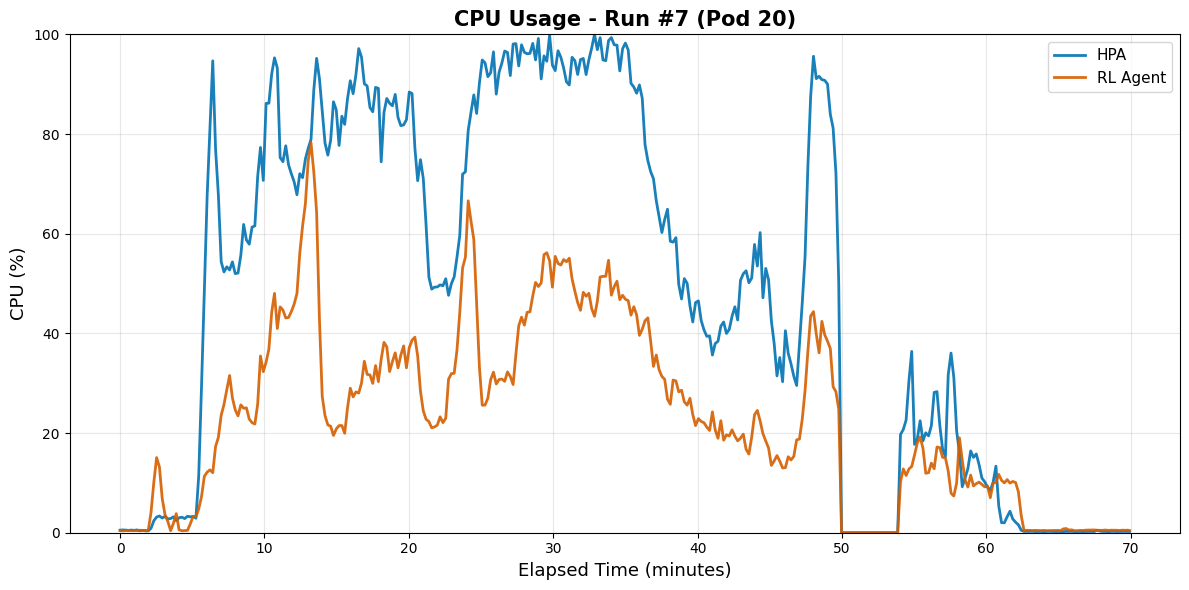

  Saved: ../pod_20/chart/recommended/cpu_run_10_recommended.png


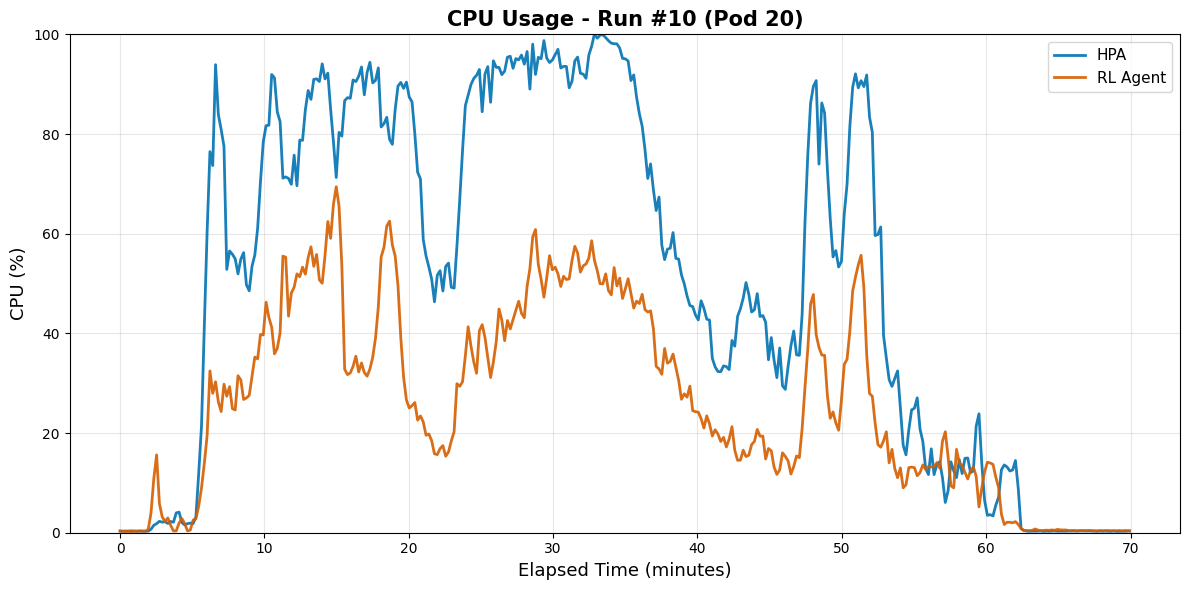

  Saved: ../pod_20/chart/recommended/cpu_run_8_recommended.png


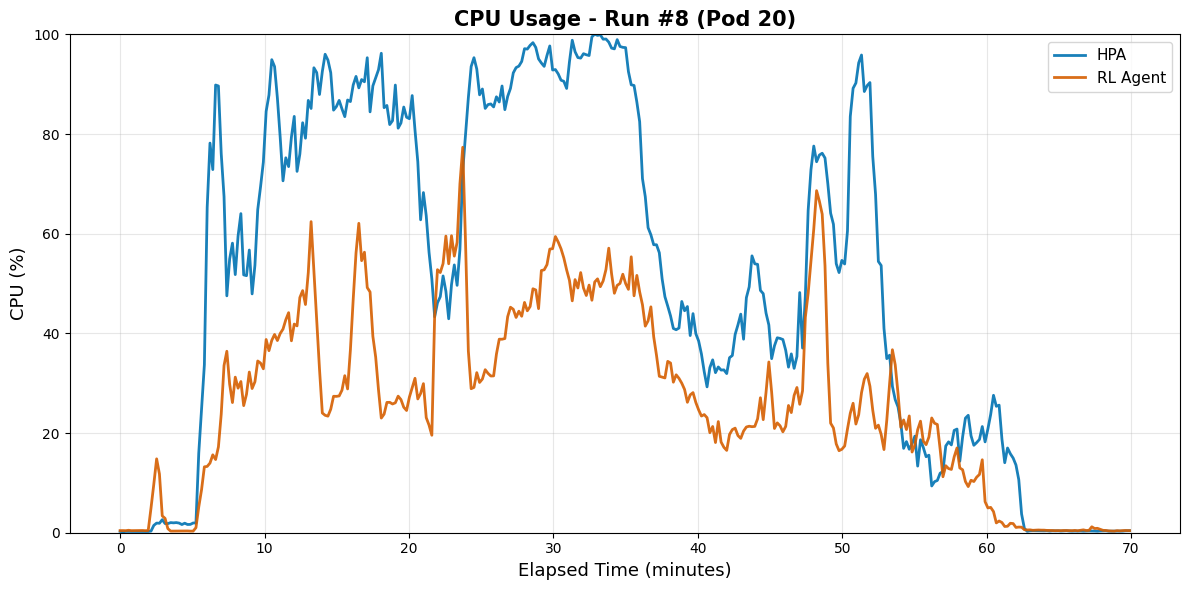


Memory Usage:
  Saved: ../pod_20/chart/recommended/memory_run_4_recommended.png


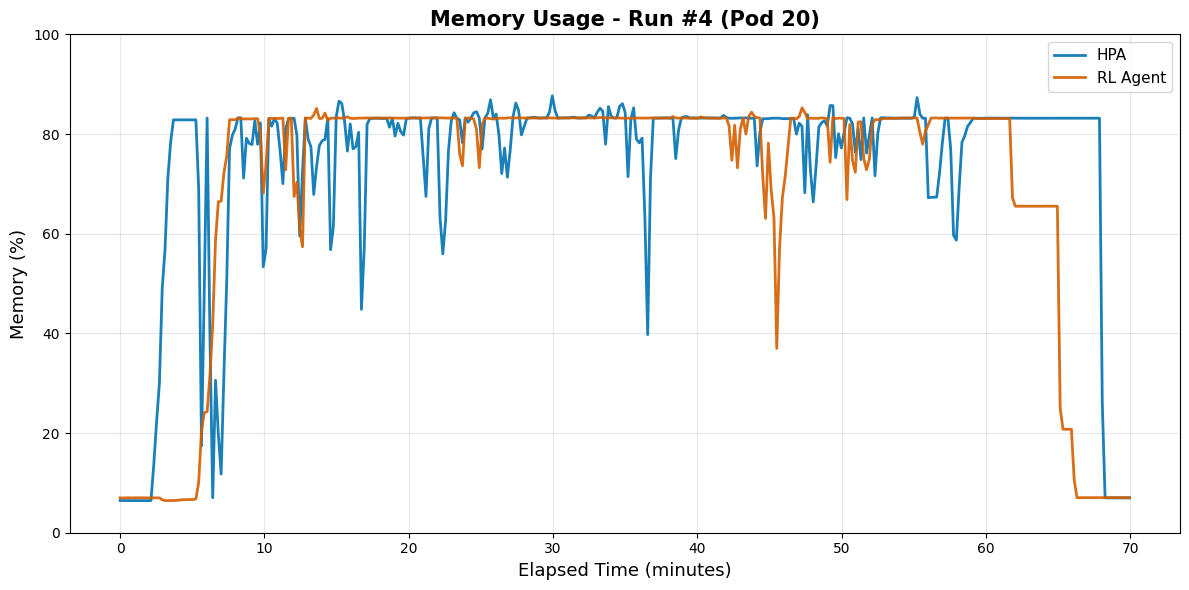

  Saved: ../pod_20/chart/recommended/memory_run_9_recommended.png


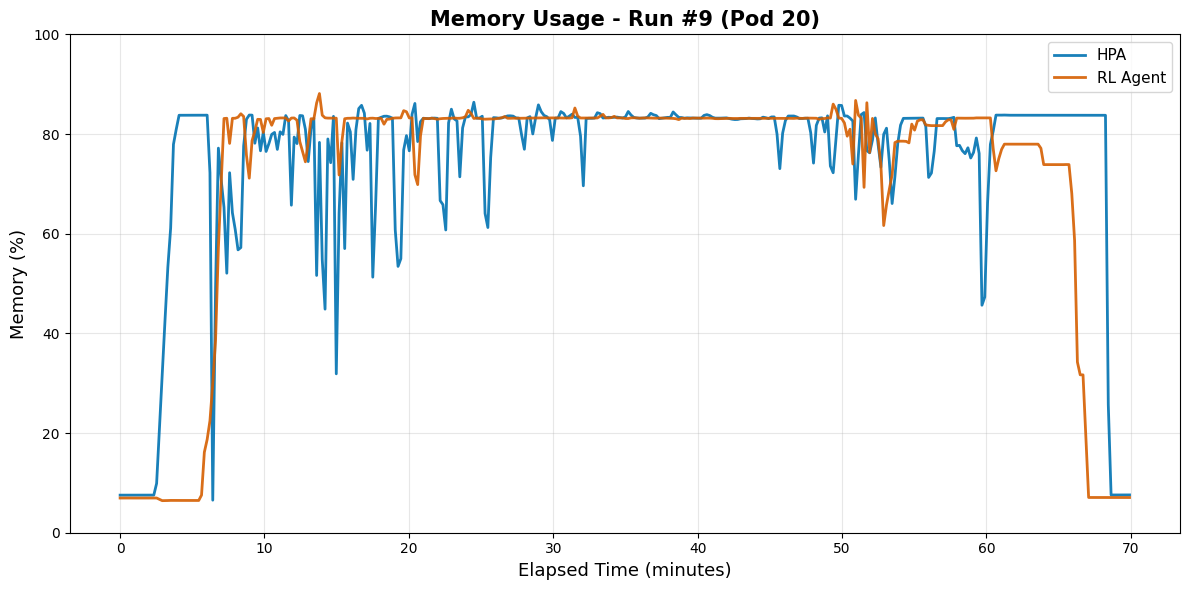

  Saved: ../pod_20/chart/recommended/memory_run_6_recommended.png


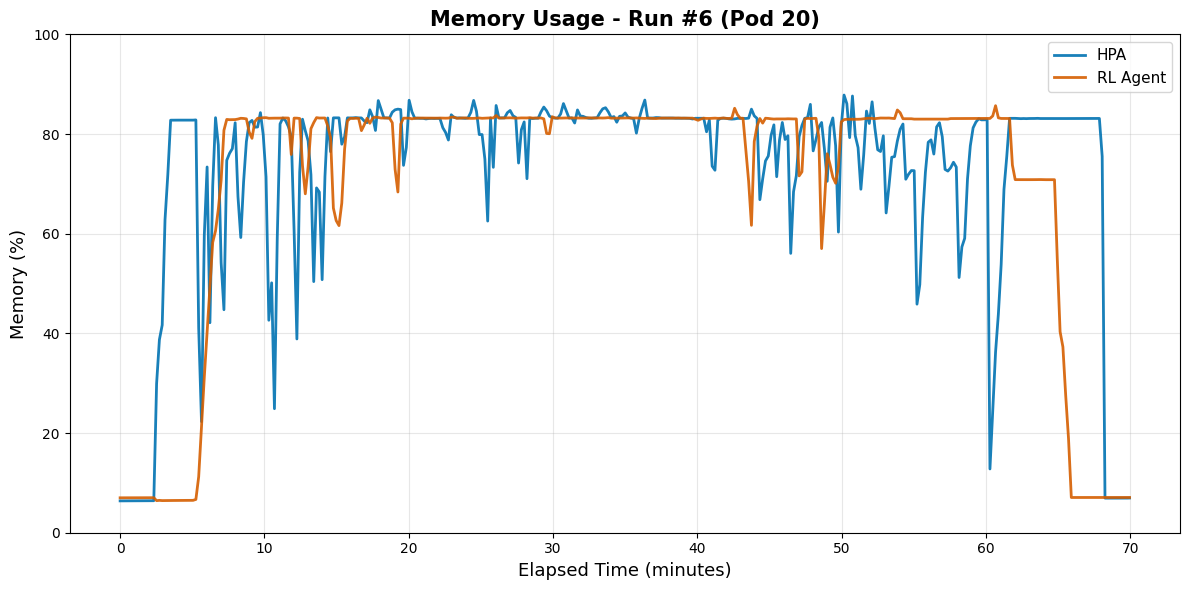


Response Time:
  Saved: ../pod_20/chart/recommended/response_time_run_7_recommended.png


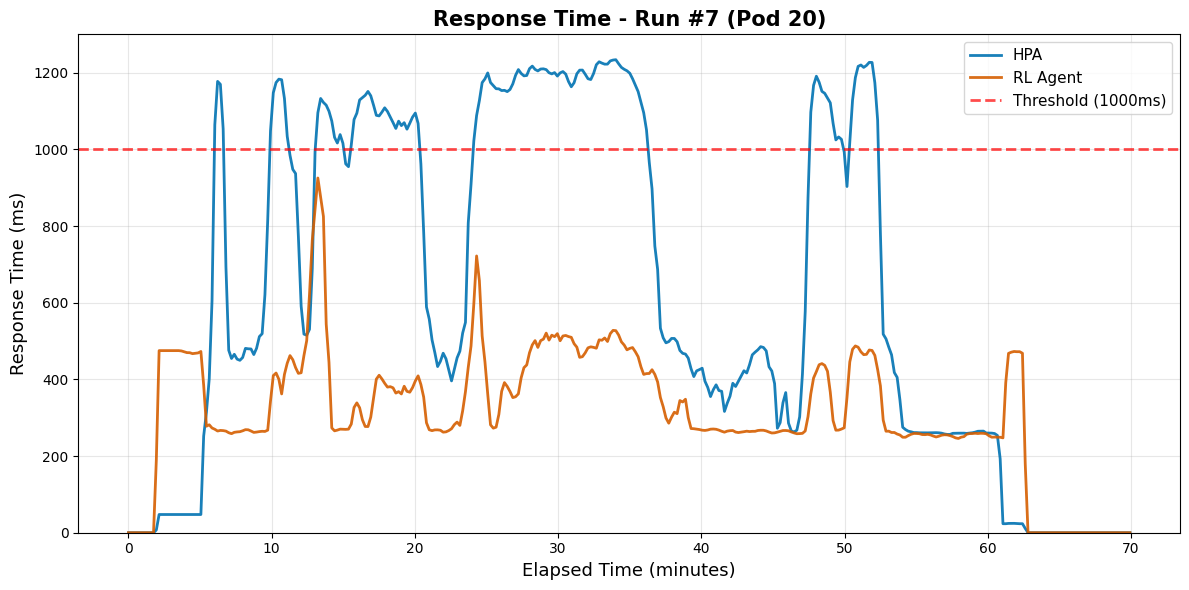

  Saved: ../pod_20/chart/recommended/response_time_run_8_recommended.png


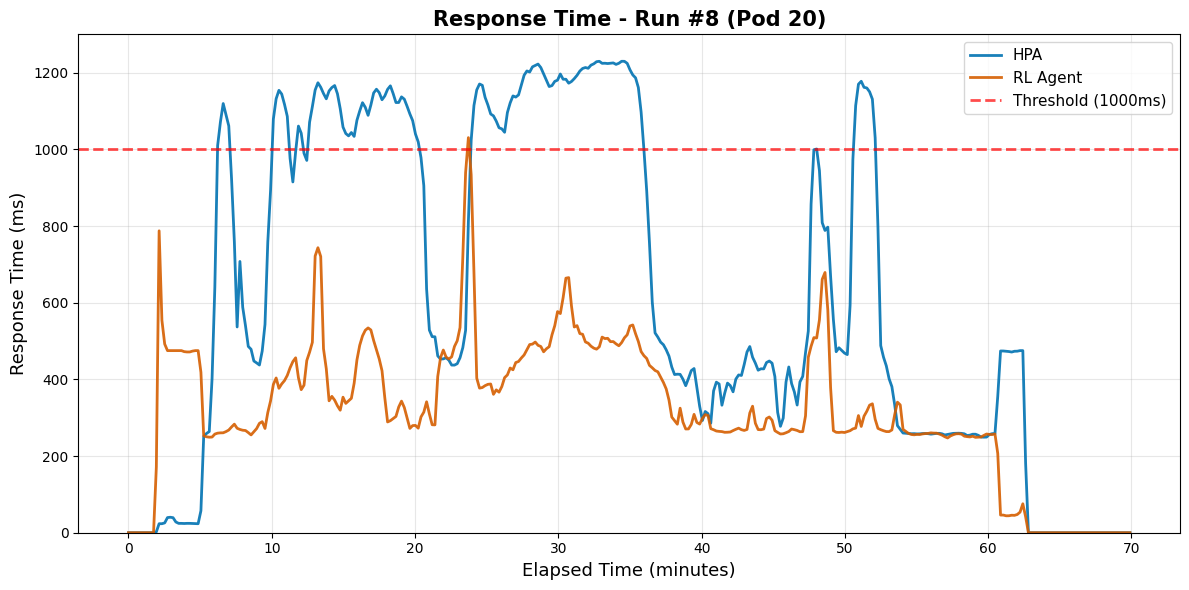

  Saved: ../pod_20/chart/recommended/response_time_run_1_recommended.png


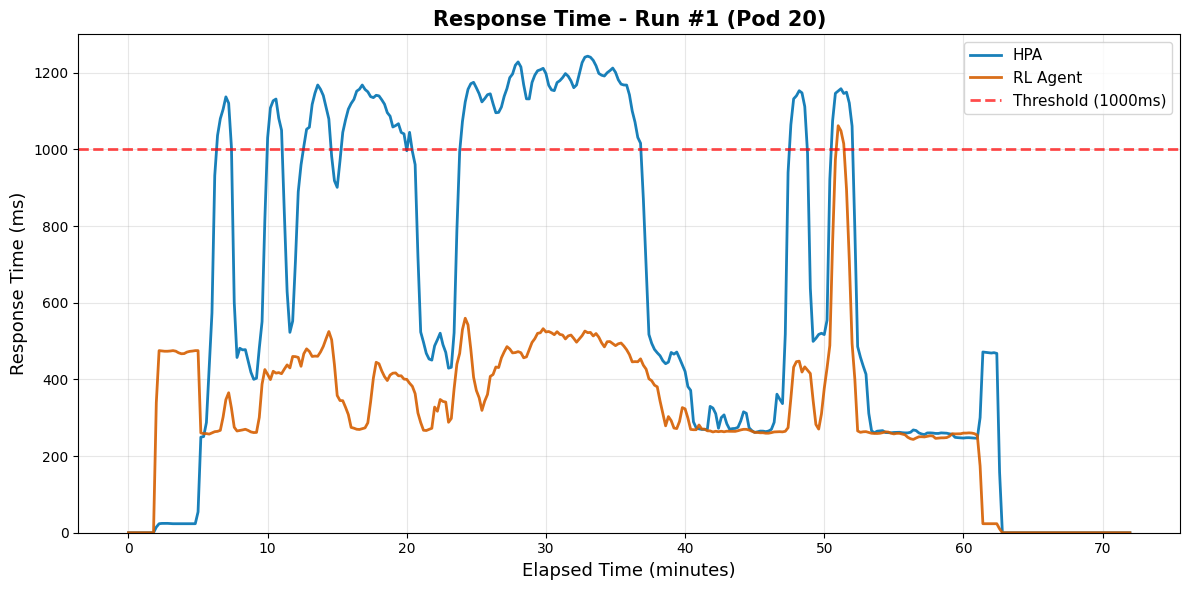


Replica Count:
  Saved: ../pod_20/chart/recommended/replicas_run_6_recommended.png


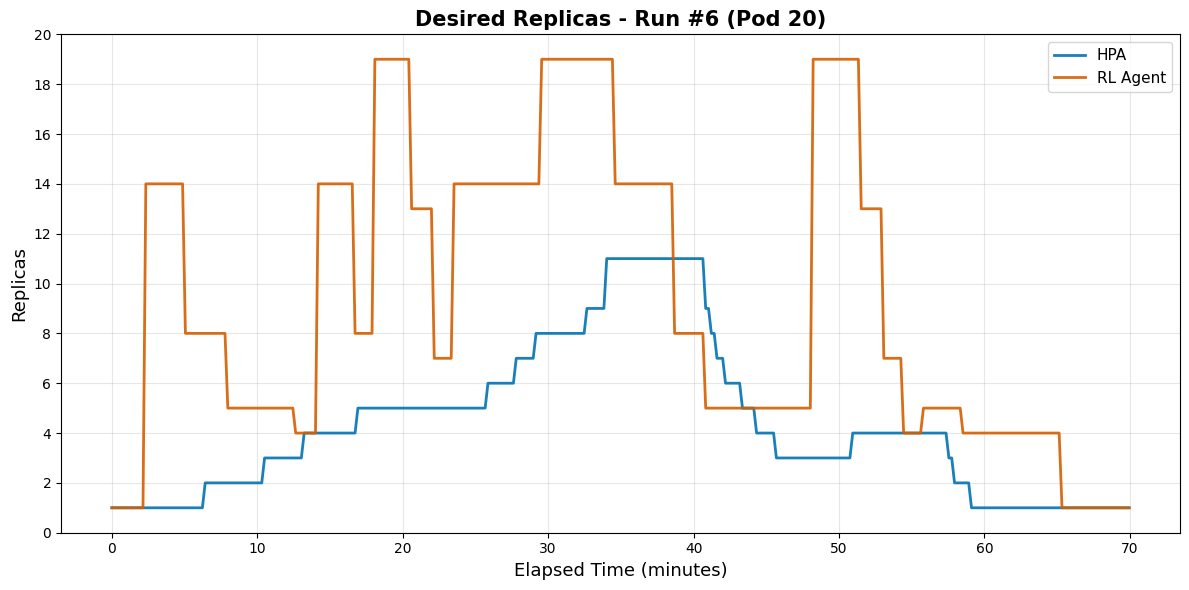

  Saved: ../pod_20/chart/recommended/replicas_run_3_recommended.png


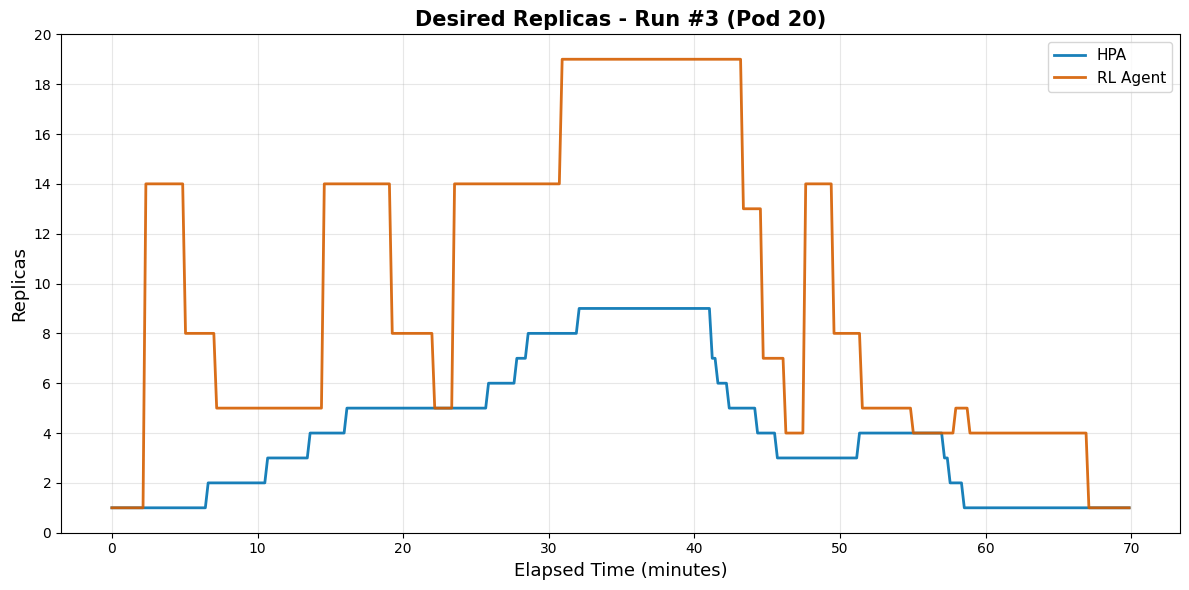

  Saved: ../pod_20/chart/recommended/replicas_run_4_recommended.png


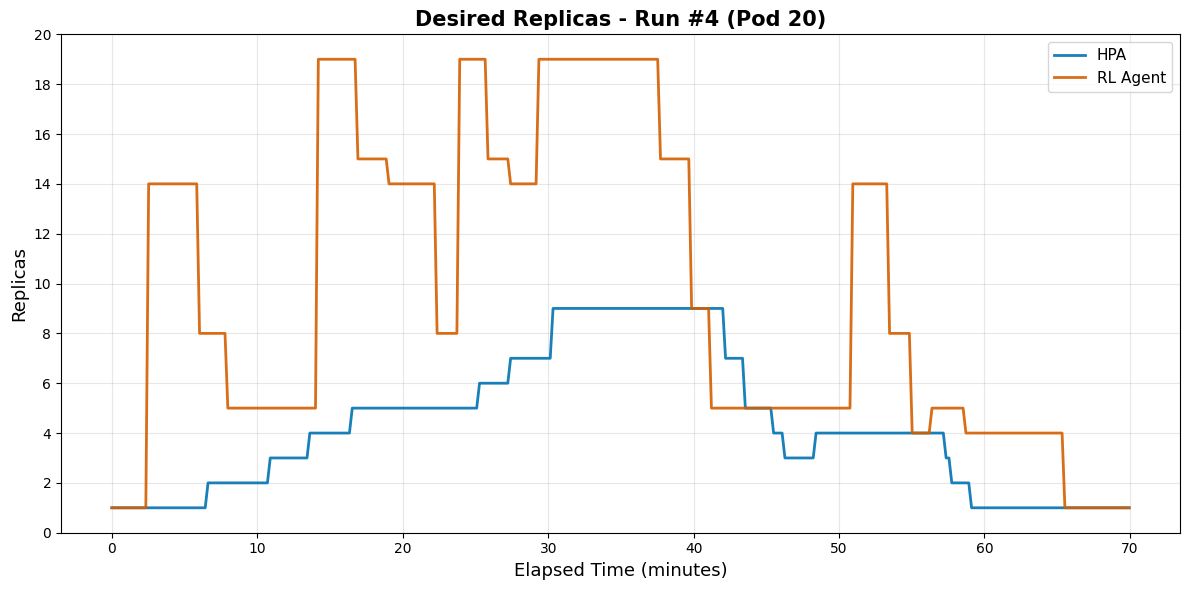


✓ All recommended run charts created for Pod 20!


In [ ]:
def plot_single_run_high_quality(df, run_id, metric_name, ylabel, ylim, threshold=None, save_path=None):
    """Create high-quality plot for a single test run"""
    DEPLOY_A = "hpa-flask-app"
    DEPLOY_B = "test-flask-app"
    COLORS = {DEPLOY_A: "#0072B2", DEPLOY_B: "#D55E00"}

    # Add elapsed time
    min_time = df["_time"].min()
    df["_elapsed_min"] = (df["_time"] - min_time).dt.total_seconds() / 60

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    for deploy in [DEPLOY_A, DEPLOY_B]:
        subset = df[df["deployment"] == deploy].sort_values("_elapsed_min")
        label = "HPA" if deploy == DEPLOY_A else "RL Agent"
        ax.plot(
            subset["_elapsed_min"],
            subset["_value"],
            label=label,
            color=COLORS[deploy],
            linewidth=2,
            alpha=0.9,
        )

    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_xlabel("Elapsed Time (minutes)", fontsize=13)
    ax.set_title(f"{metric_name} - Run #{run_id} (Pod 20)", fontsize=15, fontweight="bold")
    ax.set_ylim(0, ylim)

    if "Replicas" in metric_name:
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    if threshold:
        ax.axhline(y=threshold, color="red", linestyle="--", linewidth=2, alpha=0.7,
                  label=f"Threshold ({threshold}ms)")

    ax.legend(loc="upper right", fontsize=11)
    ax.grid(True, alpha=0.3)
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"  Saved: {save_path}")

    plt.show()
    plt.close()

# Create high-quality individual plots for top recommended runs
os.makedirs("pod_20/chart/recommended", exist_ok=True)

print("\nCreating individual high-quality plots for recommended runs (Pod 20)...")
print()

# CPU - Top 3
print("CPU Usage:")
for i, run_id in enumerate(recommendations_pod20['CPU'][:3], 1):
    run_id = int(run_id)
    if run_id in pod20_cpu_runs:
        plot_single_run_high_quality(
            pod20_cpu_runs[run_id], run_id, "CPU Usage",
            "CPU (%)", 100, None,
            f"pod_20/chart/recommended/cpu_run_{run_id}_recommended.png"
        )

# Memory - Top 3
print("\nMemory Usage:")
for i, run_id in enumerate(recommendations_pod20['Memory'][:3], 1):
    run_id = int(run_id)
    if run_id in pod20_mem_runs:
        plot_single_run_high_quality(
            pod20_mem_runs[run_id], run_id, "Memory Usage",
            "Memory (%)", 100, None,
            f"pod_20/chart/recommended/memory_run_{run_id}_recommended.png"
        )

# Response Time - Top 3
print("\nResponse Time:")
for i, run_id in enumerate(recommendations_pod20['Response Time'][:3], 1):
    run_id = int(run_id)
    if run_id in pod20_rt_runs:
        plot_single_run_high_quality(
            pod20_rt_runs[run_id], run_id, "Response Time",
            "Response Time (ms)", 1300, 1000,
            f"pod_20/chart/recommended/response_time_run_{run_id}_recommended.png"
        )

# Replicas - Top 3
print("\nReplica Count:")
for i, run_id in enumerate(recommendations_pod20['Replica'][:3], 1):
    run_id = int(run_id)
    if run_id in pod20_rep_runs:
        plot_single_run_high_quality(
            pod20_rep_runs[run_id], run_id, "Desired Replicas",
            "Replicas", 20, None,
            f"pod_20/chart/recommended/replicas_run_{run_id}_recommended.png"
        )

print("\n✓ All recommended run charts created for Pod 20!")

---

## 2. Load All Test Runs - Pod 10

In [8]:
# Load all test runs for Pod 10
print("Loading Pod 10 test runs...")
pod10_cpu_runs = load_all_runs("pod_10", "cpu", 9)
pod10_mem_runs = load_all_runs("pod_10", "memory", 9)
pod10_rep_runs = load_all_runs("pod_10", "replica", 9)
pod10_rt_runs = load_all_runs("pod_10", "response_time", 9)

print(f"✓ CPU: {len(pod10_cpu_runs)} runs")
print(f"✓ Memory: {len(pod10_mem_runs)} runs")
print(f"✓ Replica: {len(pod10_rep_runs)} runs")
print(f"✓ Response Time: {len(pod10_rt_runs)} runs")

# Calculate statistics
print("\nCalculating statistics...")
pod10_cpu_stats = calculate_run_statistics(pod10_cpu_runs, "CPU Usage (%)")
pod10_mem_stats = calculate_run_statistics(pod10_mem_runs, "Memory Usage (%)")
pod10_rep_stats = calculate_run_statistics(pod10_rep_runs, "Replica Count")
pod10_rt_stats = calculate_run_statistics(pod10_rt_runs, "Response Time (ms)")

# Combine all statistics
pod10_all_stats = pd.concat([pod10_cpu_stats, pod10_mem_stats, pod10_rep_stats, pod10_rt_stats])
print("\n" + "="*80)
print("POD 10 - Statistics Summary")
print("="*80)
print(pod10_all_stats.to_string(index=False))
print("="*80)

Loading Pod 10 test runs...
✓ CPU: 9 runs
✓ Memory: 9 runs
✓ Replica: 9 runs
✓ Response Time: 9 runs

Calculating statistics...

POD 10 - Statistics Summary
 Run             Metric   HPA Mean    RL Mean    HPA Std     RL Std     HPA Max      RL Max  Improvement (%)  Data Points  Stability
   1      CPU Usage (%)  39.794021  25.769173  31.936870  23.782663   98.859695   98.700991        35.243607          722   0.017631
   2      CPU Usage (%)  44.505136  29.289406  32.759227  21.786289   98.524191   93.018324        34.188705          722   0.018003
   3      CPU Usage (%)  45.452414  28.666945  32.785382  21.012917   98.435217   95.920903        36.929763          722   0.018249
   4      CPU Usage (%)  43.498230  30.122056  31.614555  21.591144   94.972414   96.894855        30.751076          722   0.018448
   5      CPU Usage (%)  44.908771  28.228280  31.725529  22.099253   97.784494   92.768878        37.143060          722   0.018240
   6      CPU Usage (%)  44.316900  30.333556

In [9]:
# Get recommendations for each metric (Pod 10)
print("="*80)
print("RECOMMENDATIONS FOR THESIS - POD 10")
print("="*80)

metrics_pod10 = [
    (pod10_cpu_stats, "CPU Usage", "CPU"),
    (pod10_mem_stats, "Memory Usage", "Memory"),
    (pod10_rt_stats, "Response Time", "Response Time"),
    (pod10_rep_stats, "Replica Count", "Replica")
]

recommendations_pod10 = {}

for stats_df, metric_name, metric_type in metrics_pod10:
    if len(stats_df) > 0:
        ranked = get_recommendation_score(stats_df, metric_type)
        top_3 = ranked.head(3)

        print(f"\n{metric_name}:")
        print(f"  Top 3 Recommended Runs:")
        for idx, row in top_3.iterrows():
            print(f"    #{int(row['Run'])}: Score={row['Score']:.3f}, "
                  f"Improvement={row['Improvement (%)']:.1f}%, "
                  f"HPA={row['HPA Mean']:.2f}, RL={row['RL Mean']:.2f}")

        recommendations_pod10[metric_type] = top_3['Run'].tolist()

print("\n" + "="*80)

RECOMMENDATIONS FOR THESIS - POD 10

CPU Usage:
  Top 3 Recommended Runs:
    #8: Score=0.821, Improvement=36.8%, HPA=46.01, RL=29.08
    #5: Score=0.788, Improvement=37.1%, HPA=44.91, RL=28.23
    #3: Score=0.766, Improvement=36.9%, HPA=45.45, RL=28.67

Memory Usage:
  Top 3 Recommended Runs:
    #2: Score=0.776, Improvement=14.5%, HPA=69.04, RL=59.03
    #9: Score=0.670, Improvement=4.9%, HPA=69.67, RL=66.28
    #8: Score=0.598, Improvement=5.6%, HPA=67.71, RL=63.94

Response Time:
  Top 3 Recommended Runs:
    #3: Score=0.727, Improvement=38.1%, HPA=519.81, RL=321.82
    #8: Score=0.640, Improvement=35.9%, HPA=516.64, RL=331.27
    #5: Score=0.489, Improvement=33.3%, HPA=499.33, RL=333.16

Replica Count:
  Top 3 Recommended Runs:
    #3: Score=0.801, Improvement=-85.3%, HPA=2.50, RL=4.63
    #6: Score=0.634, Improvement=-84.0%, HPA=2.46, RL=4.53
    #2: Score=0.627, Improvement=-89.3%, HPA=2.47, RL=4.67




Creating overview plots for Pod 10...

  Saved: ../pod_10/chart/all_runs/overview_cpu_all_runs.png


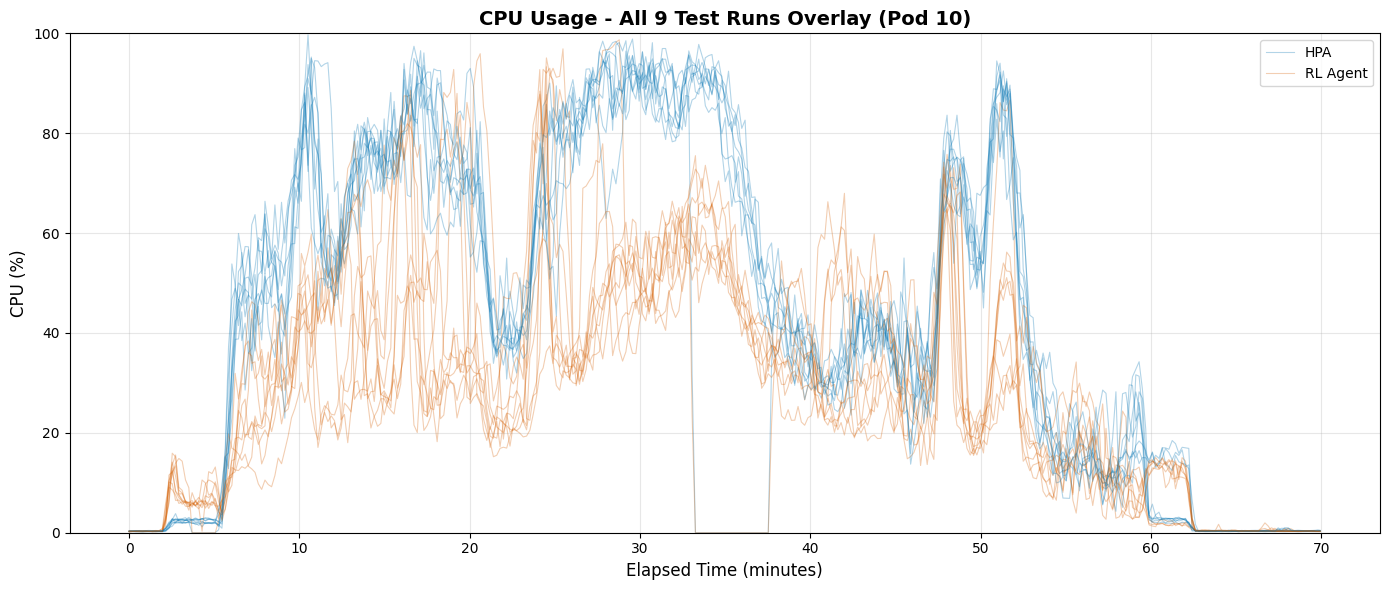

  Saved: ../pod_10/chart/all_runs/overview_memory_all_runs.png


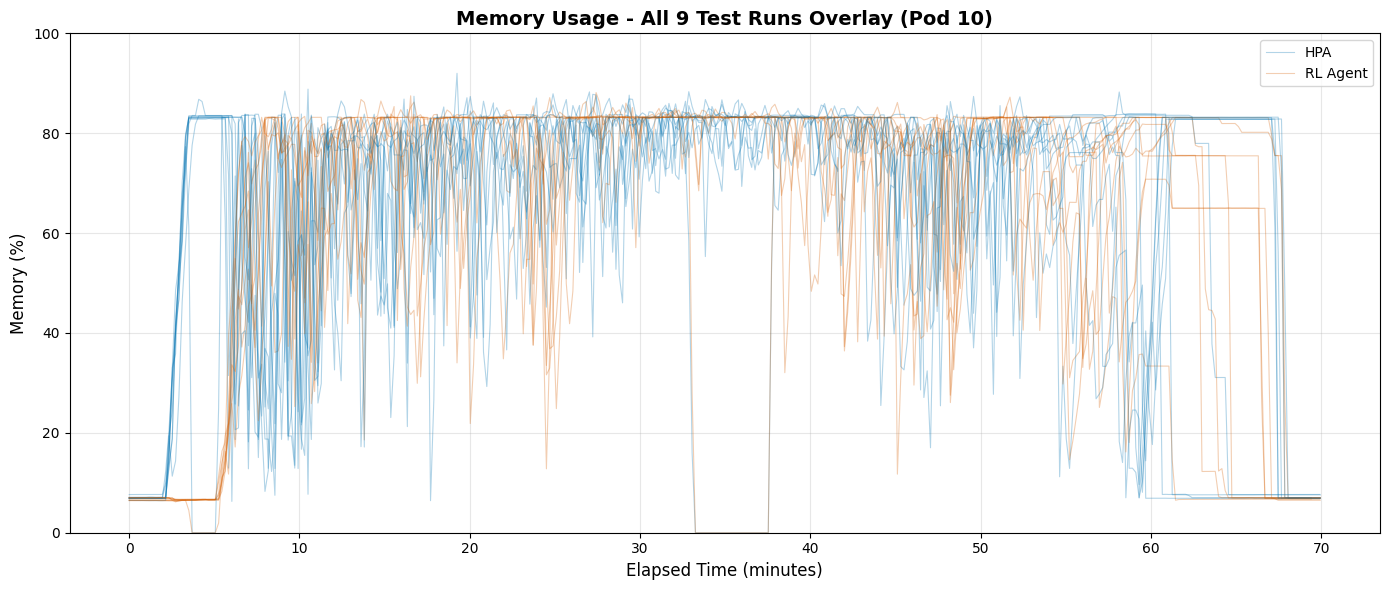

  Saved: ../pod_10/chart/all_runs/overview_response_time_all_runs.png


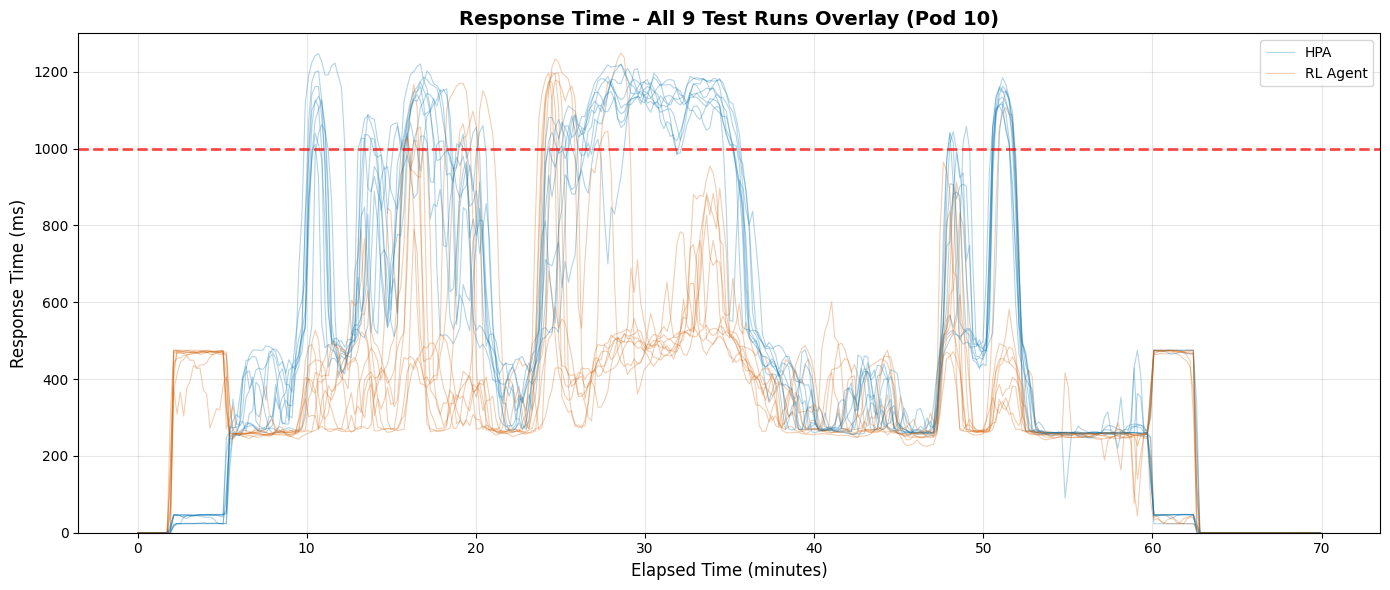

  Saved: ../pod_10/chart/all_runs/overview_replicas_all_runs.png


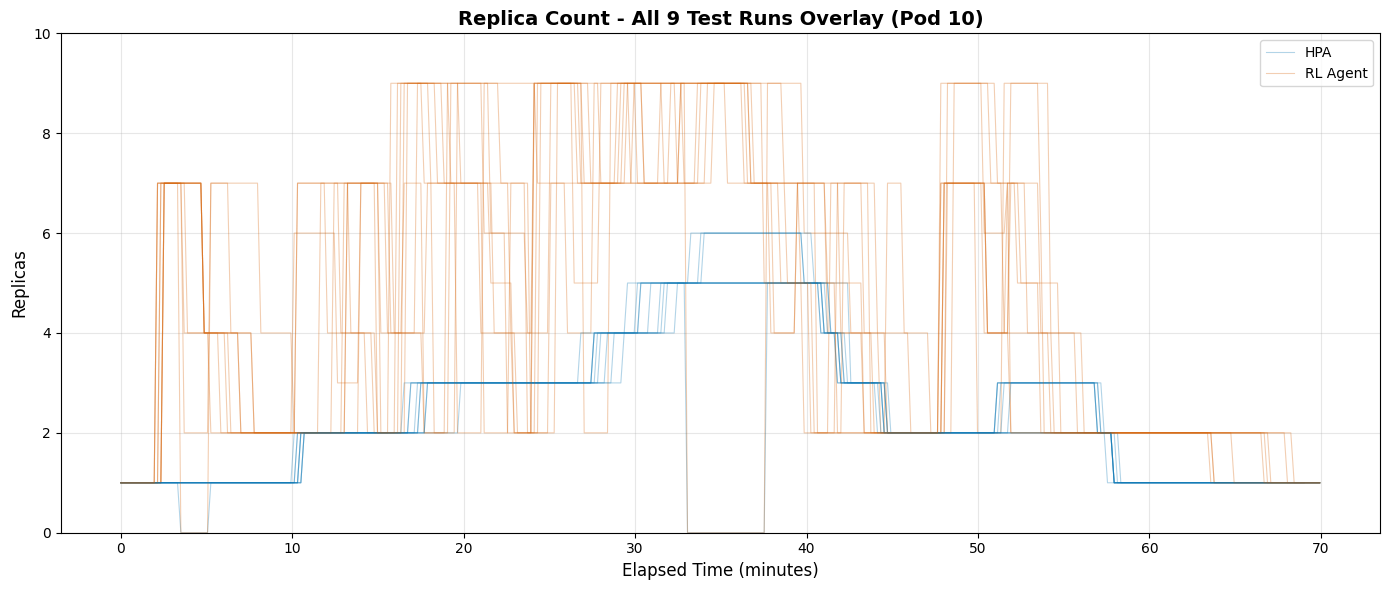

In [ ]:
# Create overview plots for Pod 10
print("\nCreating overview plots for Pod 10...")
print()

os.makedirs("pod_10/chart/all_runs", exist_ok=True)

def plot_all_runs_overview_pod10(runs_dict, metric_name, ylabel, ylim, threshold=None, save_name=None):
    """Plot all test runs in one figure for comparison (Pod 10)"""
    n_runs = len(runs_dict)
    if n_runs == 0:
        print(f"No data for {metric_name}")
        return

    fig, ax = plt.subplots(1, 1, figsize=(14, 6))

    DEPLOY_A = "hpa-flask-app"
    DEPLOY_B = "test-flask-app"

    for run_id, df in runs_dict.items():
        min_time = df["_time"].min()
        df["_elapsed_min"] = (df["_time"] - min_time).dt.total_seconds() / 60

        hpa_subset = df[df["deployment"] == DEPLOY_A].sort_values("_elapsed_min")
        if len(hpa_subset) > 0:
            ax.plot(hpa_subset["_elapsed_min"], hpa_subset["_value"],
                   color="#0072B2", alpha=0.3, linewidth=0.8, label=f"HPA" if run_id == 1 else "")

        rl_subset = df[df["deployment"] == DEPLOY_B].sort_values("_elapsed_min")
        if len(rl_subset) > 0:
            ax.plot(rl_subset["_elapsed_min"], rl_subset["_value"],
                   color="#D55E00", alpha=0.3, linewidth=0.8, label=f"RL Agent" if run_id == 1 else "")

    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel("Elapsed Time (minutes)", fontsize=12)
    ax.set_title(f"{metric_name} - All {n_runs} Test Runs Overlay (Pod 10)", fontsize=14, fontweight="bold")
    ax.set_ylim(0, ylim)
    ax.legend(loc="upper right", fontsize=10)
    ax.grid(True, alpha=0.3)

    if threshold:
        ax.axhline(y=threshold, color="red", linestyle="--", linewidth=2, alpha=0.7, label=f"Threshold ({threshold}ms)")

    fig.tight_layout()

    if save_name:
        fig.savefig(f"pod_10/chart/all_runs/{save_name}", dpi=300, bbox_inches="tight")
        print(f"  Saved: pod_10/chart/all_runs/{save_name}")

    plt.show()
    plt.close()

plot_all_runs_overview_pod10(pod10_cpu_runs, "CPU Usage", "CPU (%)", 100, None, "overview_cpu_all_runs.png")
plot_all_runs_overview_pod10(pod10_mem_runs, "Memory Usage", "Memory (%)", 100, None, "overview_memory_all_runs.png")
plot_all_runs_overview_pod10(pod10_rt_runs, "Response Time", "Response Time (ms)", 1300, 1000, "overview_response_time_all_runs.png")
plot_all_runs_overview_pod10(pod10_rep_runs, "Replica Count", "Replicas", 10, None, "overview_replicas_all_runs.png")


Creating individual high-quality plots for recommended runs (Pod 10)...

CPU Usage:
  Saved: ../pod_10/chart/recommended/cpu_run_8_recommended.png


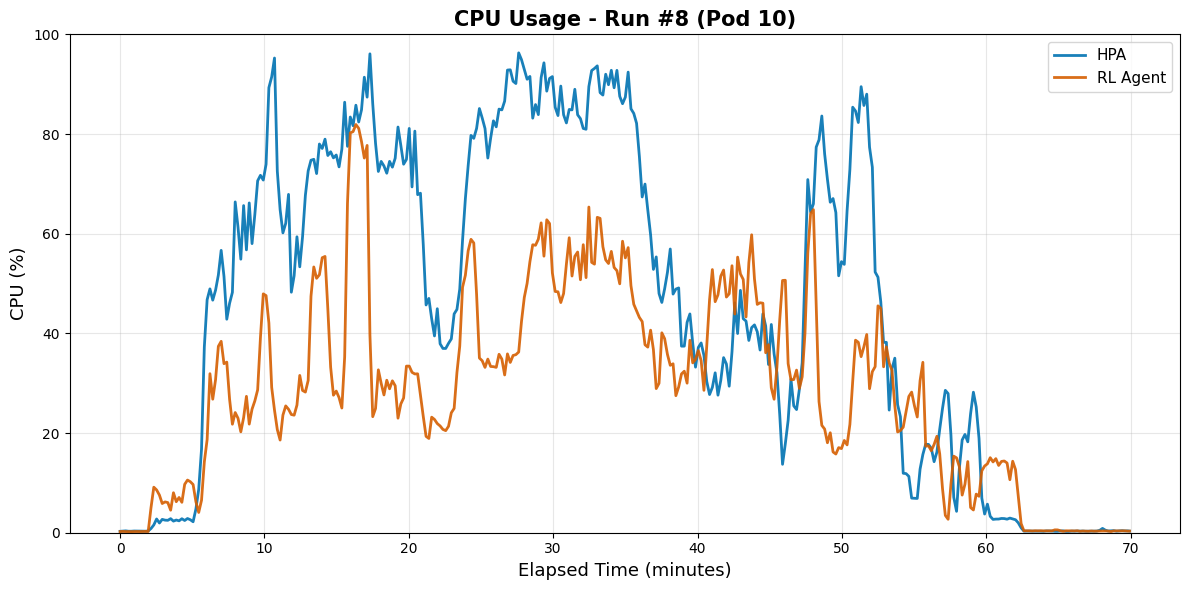

  Saved: ../pod_10/chart/recommended/cpu_run_5_recommended.png


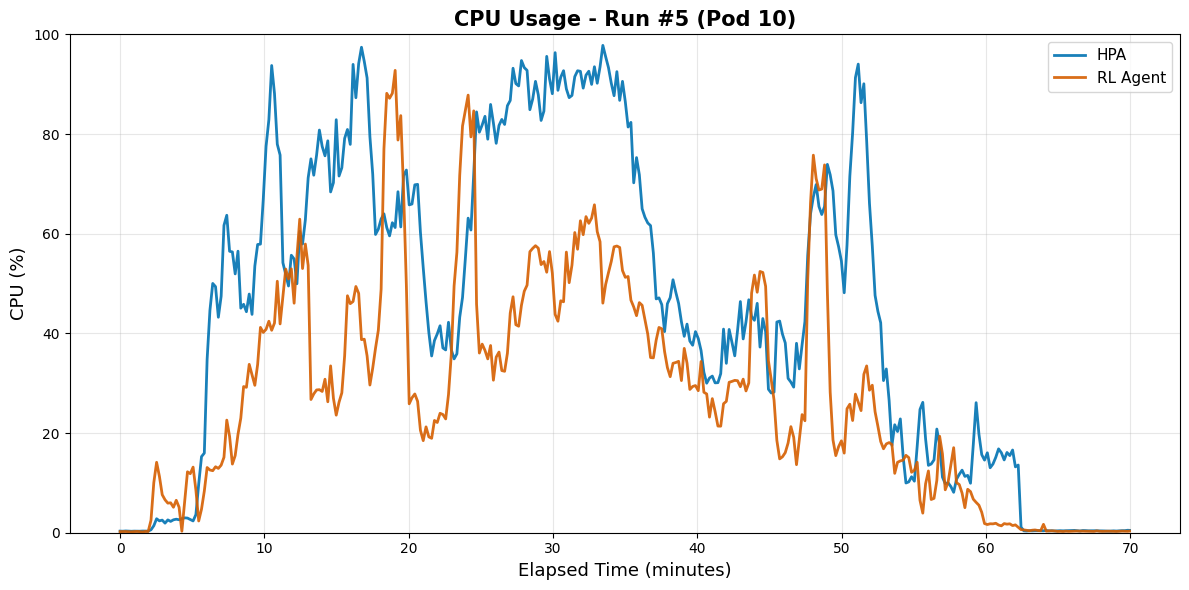

  Saved: ../pod_10/chart/recommended/cpu_run_3_recommended.png


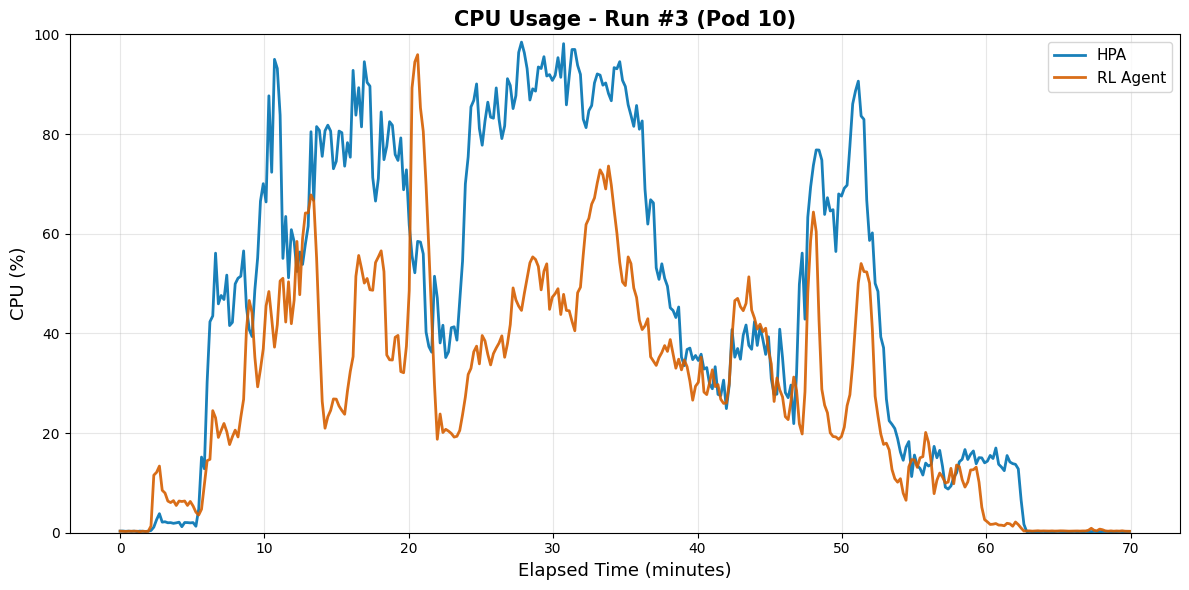


Memory Usage:
  Saved: ../pod_10/chart/recommended/memory_run_2_recommended.png


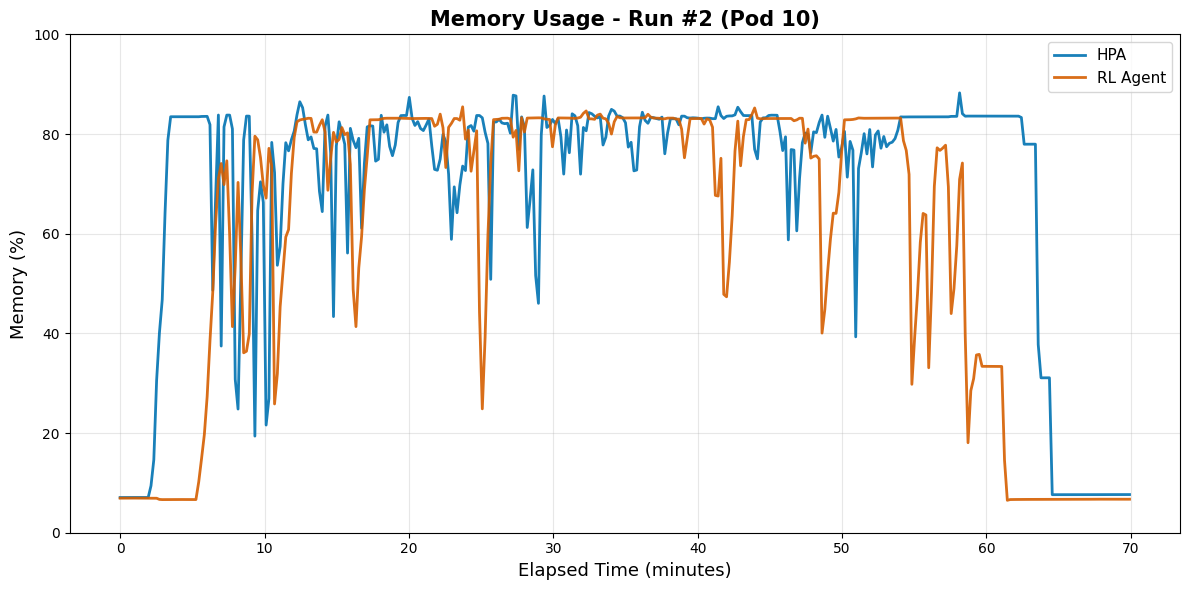

  Saved: ../pod_10/chart/recommended/memory_run_9_recommended.png


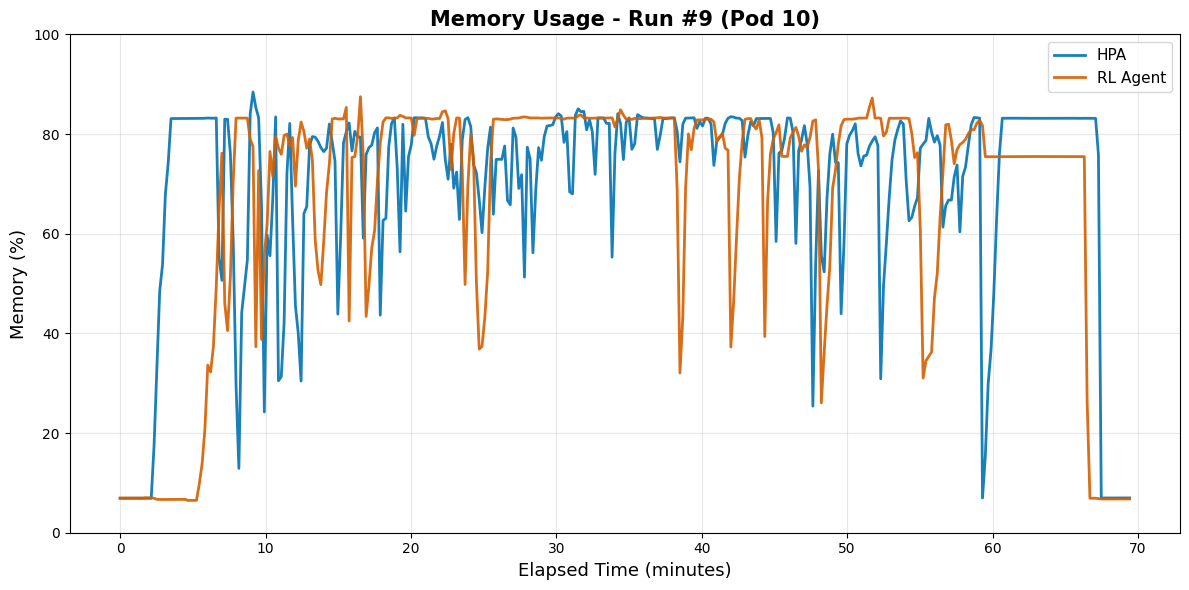

  Saved: ../pod_10/chart/recommended/memory_run_8_recommended.png


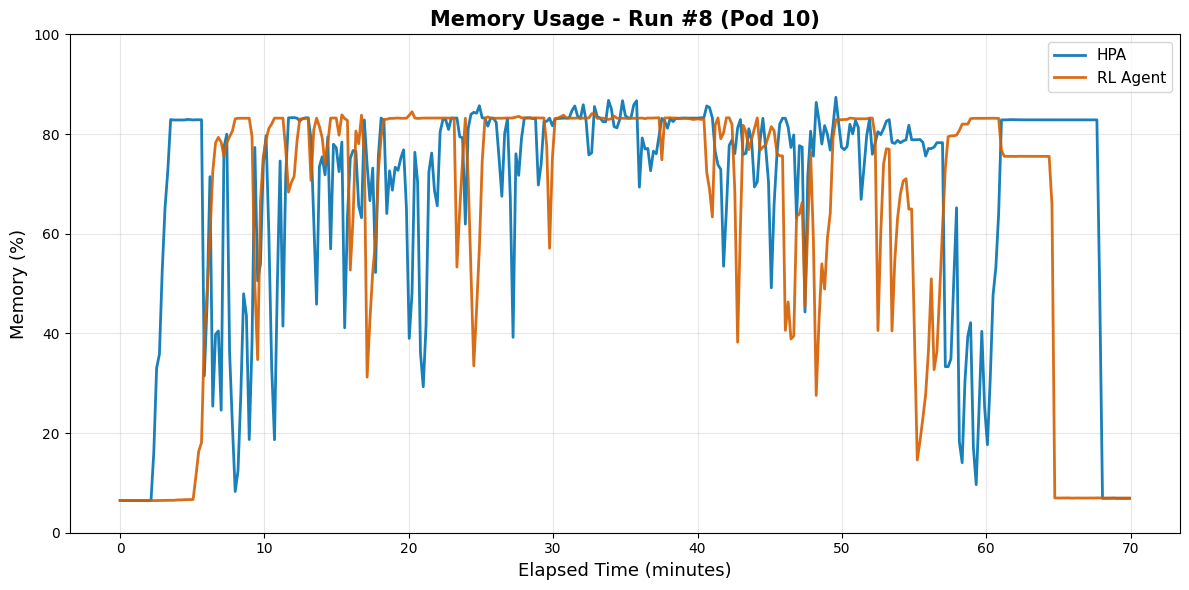


Response Time:
  Saved: ../pod_10/chart/recommended/response_time_run_3_recommended.png


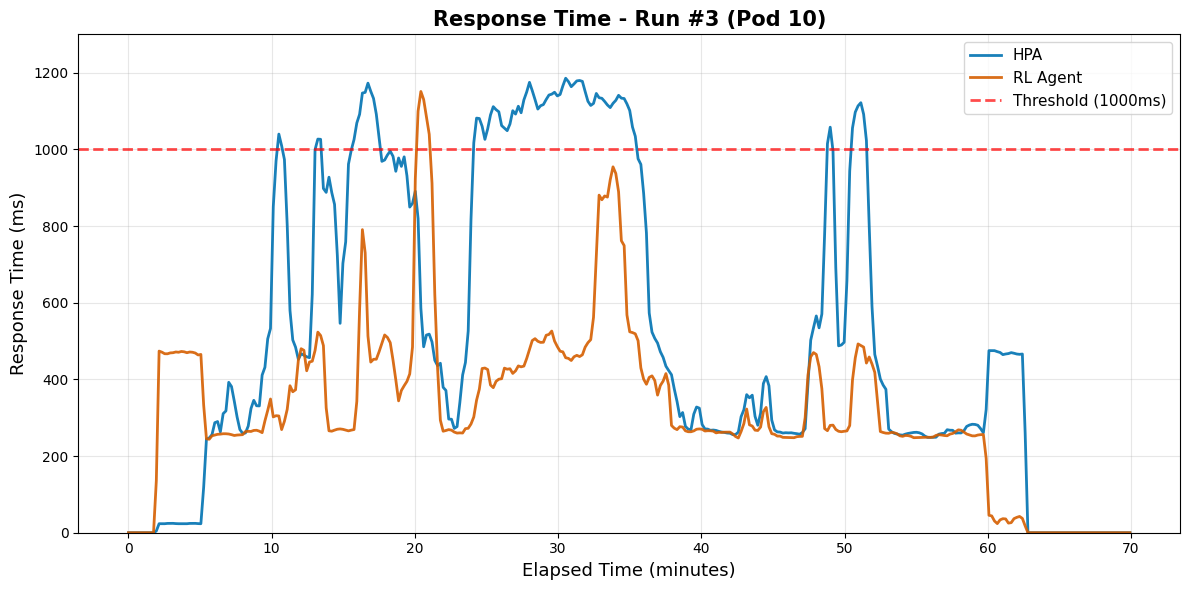

  Saved: ../pod_10/chart/recommended/response_time_run_8_recommended.png


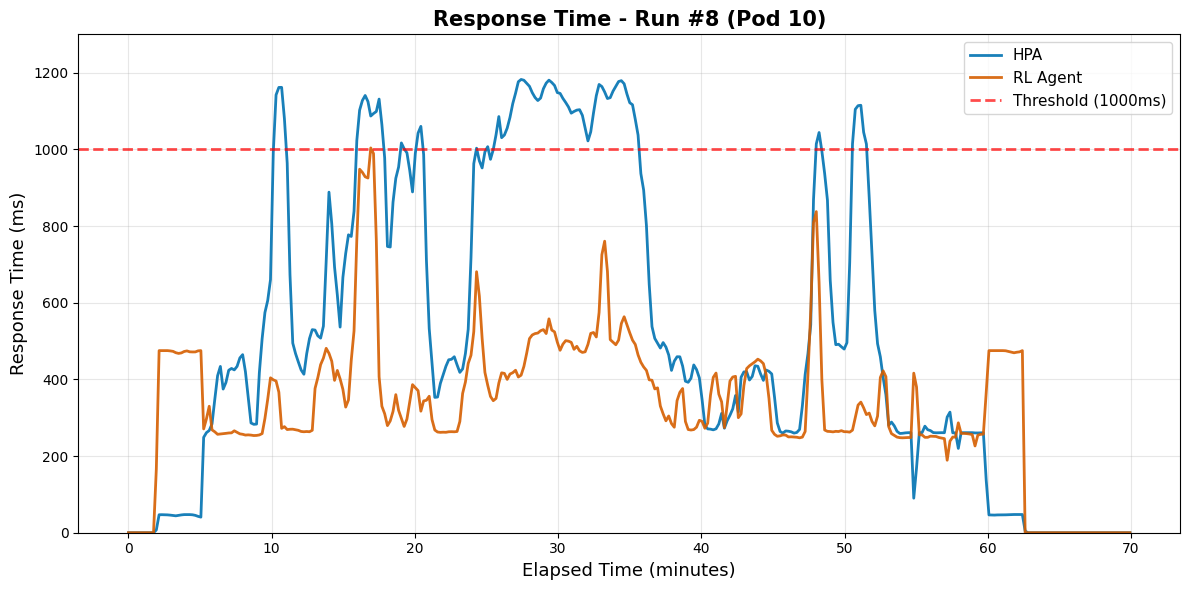

  Saved: ../pod_10/chart/recommended/response_time_run_5_recommended.png


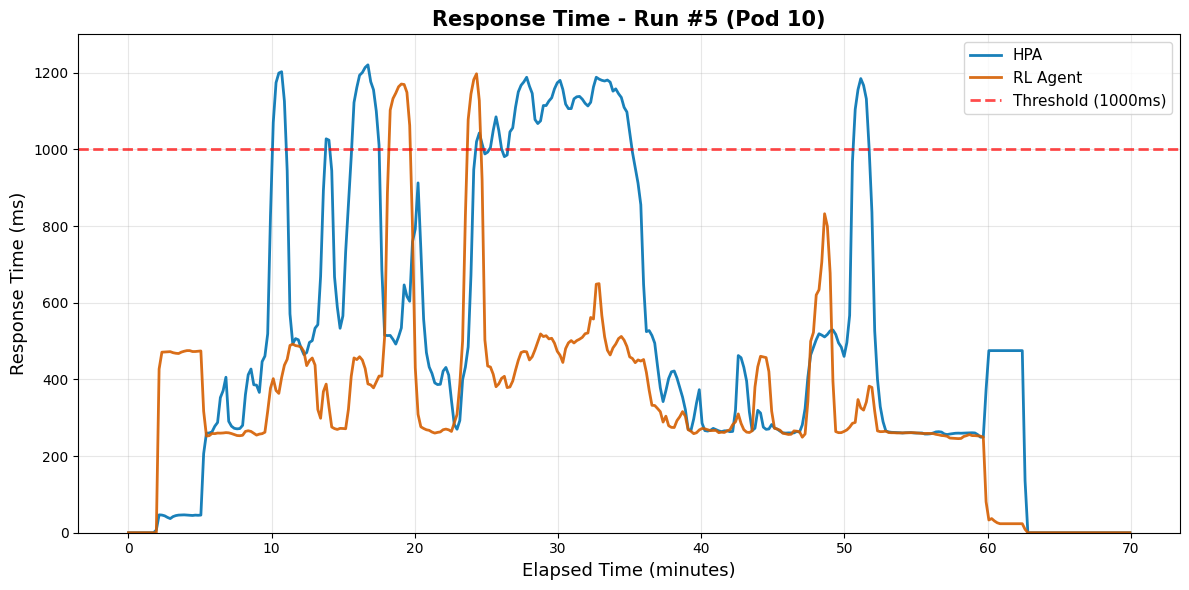


Replica Count:
  Saved: ../pod_10/chart/recommended/replicas_run_3_recommended.png


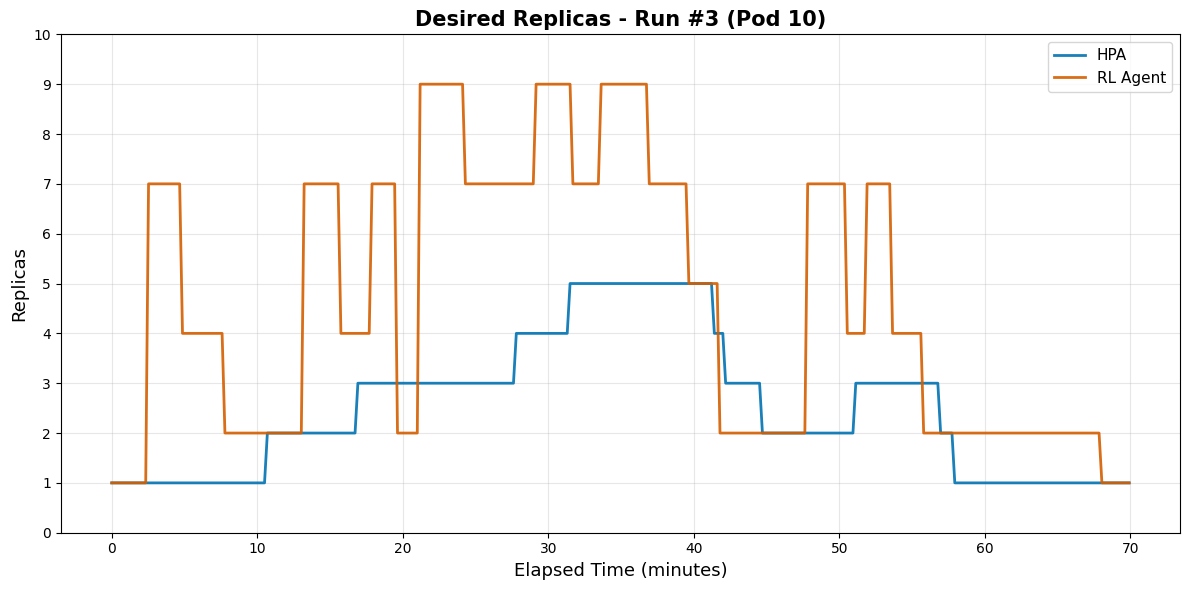

  Saved: ../pod_10/chart/recommended/replicas_run_6_recommended.png


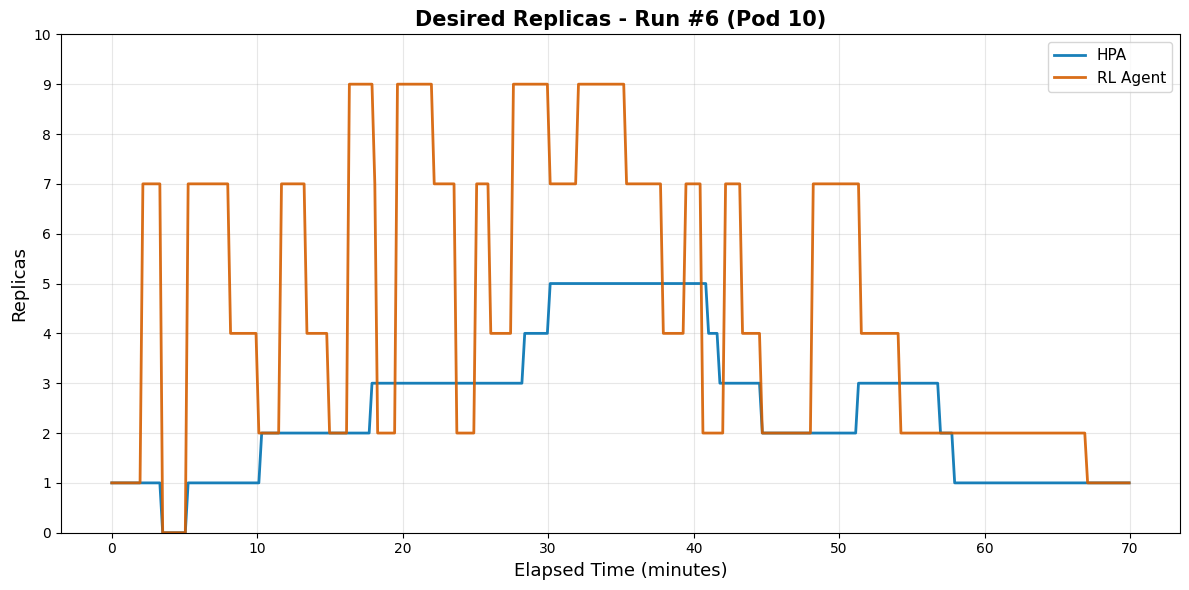

  Saved: ../pod_10/chart/recommended/replicas_run_2_recommended.png


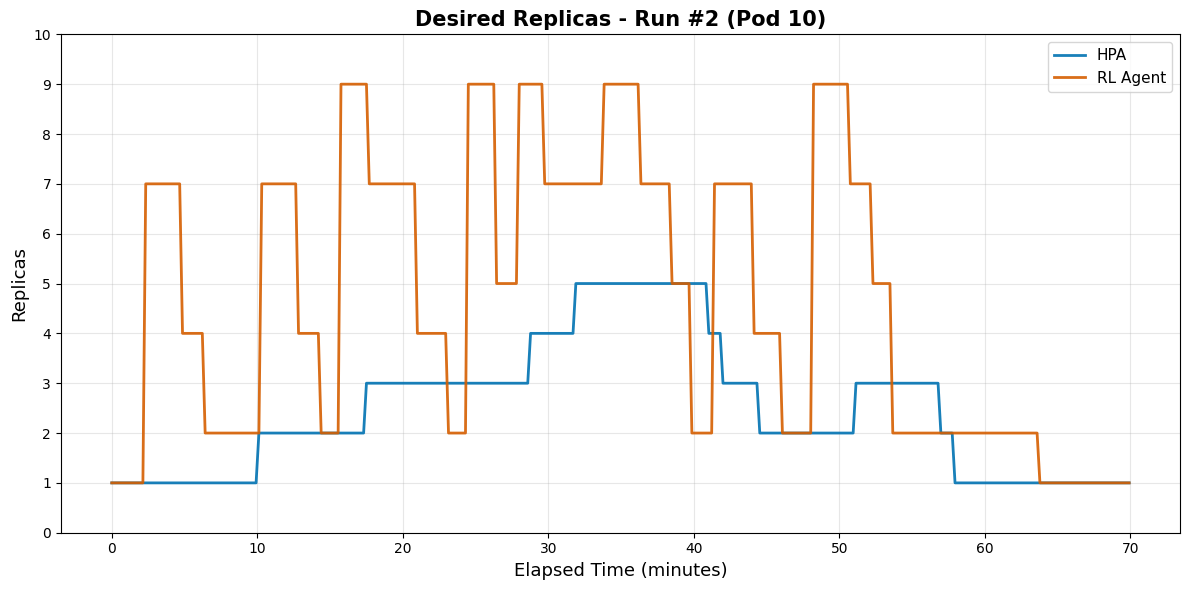


✓ All recommended run charts created for Pod 10!


In [ ]:
# Create high-quality individual plots for top recommended runs (Pod 10)
os.makedirs("pod_10/chart/recommended", exist_ok=True)

def plot_single_run_high_quality_pod10(df, run_id, metric_name, ylabel, ylim, threshold=None, save_path=None):
    """Create high-quality plot for a single test run (Pod 10)"""
    DEPLOY_A = "hpa-flask-app"
    DEPLOY_B = "test-flask-app"
    COLORS = {DEPLOY_A: "#0072B2", DEPLOY_B: "#D55E00"}

    min_time = df["_time"].min()
    df["_elapsed_min"] = (df["_time"] - min_time).dt.total_seconds() / 60

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    for deploy in [DEPLOY_A, DEPLOY_B]:
        subset = df[df["deployment"] == deploy].sort_values("_elapsed_min")
        label = "HPA" if deploy == DEPLOY_A else "RL Agent"
        ax.plot(subset["_elapsed_min"], subset["_value"],
                label=label, color=COLORS[deploy],
                linewidth=2, alpha=0.9)

    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_xlabel("Elapsed Time (minutes)", fontsize=13)
    ax.set_title(f"{metric_name} - Run #{run_id} (Pod 10)", fontsize=15, fontweight="bold")
    ax.set_ylim(0, ylim)

    if "Replicas" in metric_name:
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    if threshold:
        ax.axhline(y=threshold, color="red", linestyle="--", linewidth=2, alpha=0.7,
                  label=f"Threshold ({threshold}ms)")

    ax.legend(loc="upper right", fontsize=11)
    ax.grid(True, alpha=0.3)
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"  Saved: {save_path}")

    plt.show()
    plt.close()

print("\nCreating individual high-quality plots for recommended runs (Pod 10)...")
print()

# CPU - Top 3
print("CPU Usage:")
for i, run_id in enumerate(recommendations_pod10['CPU'][:3], 1):
    run_id = int(run_id)
    if run_id in pod10_cpu_runs:
        plot_single_run_high_quality_pod10(
            pod10_cpu_runs[run_id], run_id, "CPU Usage",
            "CPU (%)", 100, None,
            f"pod_10/chart/recommended/cpu_run_{run_id}_recommended.png"
        )

# Memory - Top 3
print("\nMemory Usage:")
for i, run_id in enumerate(recommendations_pod10['Memory'][:3], 1):
    run_id = int(run_id)
    if run_id in pod10_mem_runs:
        plot_single_run_high_quality_pod10(
            pod10_mem_runs[run_id], run_id, "Memory Usage",
            "Memory (%)", 100, None,
            f"pod_10/chart/recommended/memory_run_{run_id}_recommended.png"
        )

# Response Time - Top 3
print("\nResponse Time:")
for i, run_id in enumerate(recommendations_pod10['Response Time'][:3], 1):
    run_id = int(run_id)
    if run_id in pod10_rt_runs:
        plot_single_run_high_quality_pod10(
            pod10_rt_runs[run_id], run_id, "Response Time",
            "Response Time (ms)", 1300, 1000,
            f"pod_10/chart/recommended/response_time_run_{run_id}_recommended.png"
        )

# Replicas - Top 3
print("\nReplica Count:")
for i, run_id in enumerate(recommendations_pod10['Replica'][:3], 1):
    run_id = int(run_id)
    if run_id in pod10_rep_runs:
        plot_single_run_high_quality_pod10(
            pod10_rep_runs[run_id], run_id, "Desired Replicas",
            "Replicas", 10, None,
            f"pod_10/chart/recommended/replicas_run_{run_id}_recommended.png"
        )

print("\n✓ All recommended run charts created for Pod 10!")

---

## 📊 Final Summary for Thesis Selection

### Output Structure:

```
result/
├── pod_20/chart/
│   ├── all_runs/           # Overview dengan semua test run overlay
│   │   ├── overview_cpu_all_runs.png
│   │   ├── overview_memory_all_runs.png
│   │   ├── overview_response_time_all_runs.png
│   │   └── overview_replicas_all_runs.png
│   └── recommended/       # Grafik berkualitas tinggi untuk run terbaik
│       ├── cpu_run_X_recommended.png
│       ├── memory_run_X_recommended.png
│       ├── response_time_run_X_recommended.png
│       └── replicas_run_X_recommended.png
│
└── pod_10/chart/
    ├── all_runs/           # Overview dengan semua test run overlay
    └── recommended/        # Grafik berkualitas tinggi untuk run terbaik
```

### Kriteria Pemilihan:
1. **Improvement Score**: Seberapa besar RL Agent lebih baik dari HPA
2. **Stability**: Konsistensi performa (variance rendah)
3. **Visual Clarity**: Grafik mudah dibaca dan menunjukkan perbedaan jelas
4. **Data Quality**: Kelengkapan data dan tidak ada anomali

### Cara Memilih:
1. Review statistik di atas untuk melihat run dengan score tertinggi
2. Buka grafik overview untuk melihat pola umum
3. Periksa recommended runs untuk detail
4. Pilih run yang:
   - Menunjukkan improvement yang signifikan
   - Memiliki data lengkap dan bersih
   - Visualnya jelas dan mudah dipahami
   - Merepresentasikan hasil keseluruhan eksperimen dengan baik

In [ ]:
# Create comprehensive summary for easy decision making
print("="*100)
print("COMPREHENSIVE THESIS SELECTION GUIDE")
print("="*100)

print("\n📌 POD 20 - TOP RECOMMENDATIONS:")
print("-" * 100)
for metric_type in ['CPU', 'Memory', 'Response Time', 'Replica']:
    if metric_type in recommendations_pod20:
        runs = [int(r) for r in recommendations_pod20[metric_type][:3]]
        print(f"  {metric_type:20s}: Run #{runs[0]} (Best)  |  Run #{runs[1]} (Alternative 1)  |  Run #{runs[2]} (Alternative 2)")

print("\n📌 POD 10 - TOP RECOMMENDATIONS:")
print("-" * 100)
for metric_type in ['CPU', 'Memory', 'Response Time', 'Replica']:
    if metric_type in recommendations_pod10:
        runs = [int(r) for r in recommendations_pod10[metric_type][:3]]
        print(f"  {metric_type:20s}: Run #{runs[0]} (Best)  |  Run #{runs[1]} (Alternative 1)  |  Run #{runs[2]} (Alternative 2)")

print("\n" + "="*100)
print("✅ RECOMMENDATION: Use 'Best' runs for main thesis figures")
print("   Use 'Alternative' runs if Best has any visual issues")
print("="*100)

# Save recommendations to file for reference
with open("recommendations_for_thesis.txt", "w") as f:
    f.write("THESIS VISUALIZATION RECOMMENDATIONS\n")
    f.write("="*80 + "\n\n")
    f.write("Generated automatically based on:\n")
    f.write("- Performance improvement (HPA vs RL Agent)\n")
    f.write("- Data stability and consistency\n")
    f.write("- Visual clarity\n\n")

    f.write("POD 20 RECOMMENDATIONS:\n")
    f.write("-" * 80 + "\n")
    for metric_type in ['CPU', 'Memory', 'Response Time', 'Replica']:
        if metric_type in recommendations_pod20:
            runs = [int(r) for r in recommendations_pod20[metric_type][:3]]
            f.write(f"  {metric_type}:\n")
            f.write(f"    Primary:       Run #{runs[0]}\n")
            f.write(f"    Alternative 1: Run #{runs[1]}\n")
            f.write(f"    Alternative 2: Run #{runs[2]}\n\n")

    f.write("\nPOD 10 RECOMMENDATIONS:\n")
    f.write("-" * 80 + "\n")
    for metric_type in ['CPU', 'Memory', 'Response Time', 'Replica']:
        if metric_type in recommendations_pod10:
            runs = [int(r) for r in recommendations_pod10[metric_type][:3]]
            f.write(f"  {metric_type}:\n")
            f.write(f"    Primary:       Run #{runs[0]}\n")
            f.write(f"    Alternative 1: Run #{runs[1]}\n")
            f.write(f"    Alternative 2: Run #{runs[2]}\n\n")

    f.write("\nCHARTS LOCATION:\n")
    f.write("-" * 80 + "\n")
    f.write("  Recommended runs: result/deskriptif_test/pod_XX/chart/recommended/\n")
    f.write("  All runs overlay: result/deskriptif_test/pod_XX/chart/all_runs/\n")

print("\n💾 Recommendations saved to: result/deskriptif_test/recommendations_for_thesis.txt")

COMPREHENSIVE THESIS SELECTION GUIDE

📌 POD 20 - TOP RECOMMENDATIONS:
----------------------------------------------------------------------------------------------------
  CPU                 : Run #7 (Best)  |  Run #10 (Alternative 1)  |  Run #8 (Alternative 2)
  Memory              : Run #4 (Best)  |  Run #9 (Alternative 1)  |  Run #6 (Alternative 2)
  Response Time       : Run #7 (Best)  |  Run #8 (Alternative 1)  |  Run #1 (Alternative 2)
  Replica             : Run #6 (Best)  |  Run #3 (Alternative 1)  |  Run #4 (Alternative 2)

📌 POD 10 - TOP RECOMMENDATIONS:
----------------------------------------------------------------------------------------------------
  CPU                 : Run #8 (Best)  |  Run #5 (Alternative 1)  |  Run #3 (Alternative 2)
  Memory              : Run #2 (Best)  |  Run #9 (Alternative 1)  |  Run #8 (Alternative 2)
  Response Time       : Run #3 (Best)  |  Run #8 (Alternative 1)  |  Run #5 (Alternative 2)
  Replica             : Run #3 (Best)  |  Run #6 (

In [13]:
# Load all pod_20 datasets

base = "pod_20"
df_cpu = load_influx_csv(f"{base}/cpu_20.csv")
df_mem = load_influx_csv(f"{base}/memori_20.csv")
df_rep = load_influx_csv(f"{base}/replika_20.csv")
df_rt  = load_influx_csv(f"{base}/waktu_respon_20.csv")

# Convert to relative time (elapsed minutes from start)
min_time = min(df_cpu["_time"].min(), df_mem["_time"].min(),
               df_rep["_time"].min(), df_rt["_time"].min())

for df in [df_cpu, df_mem, df_rep, df_rt]:
    df["_elapsed_min"] = (df["_time"] - min_time).dt.total_seconds() / 60

print(f"CPU  rows: {len(df_cpu)},  deployments: {df_cpu['deployment'].unique()}")
print(f"MEM  rows: {len(df_mem)},  deployments: {df_mem['deployment'].unique()}")
print(f"REP  rows: {len(df_rep)},  deployments: {df_rep['deployment'].unique()}")
print(f"RT   rows: {len(df_rt)},   deployments: {df_rt['deployment'].unique()}")

FileNotFoundError: [Errno 2] No such file or directory: 'pod_20/cpu_20.csv'

✓ All pod_20 charts saved to pod_20/chart/


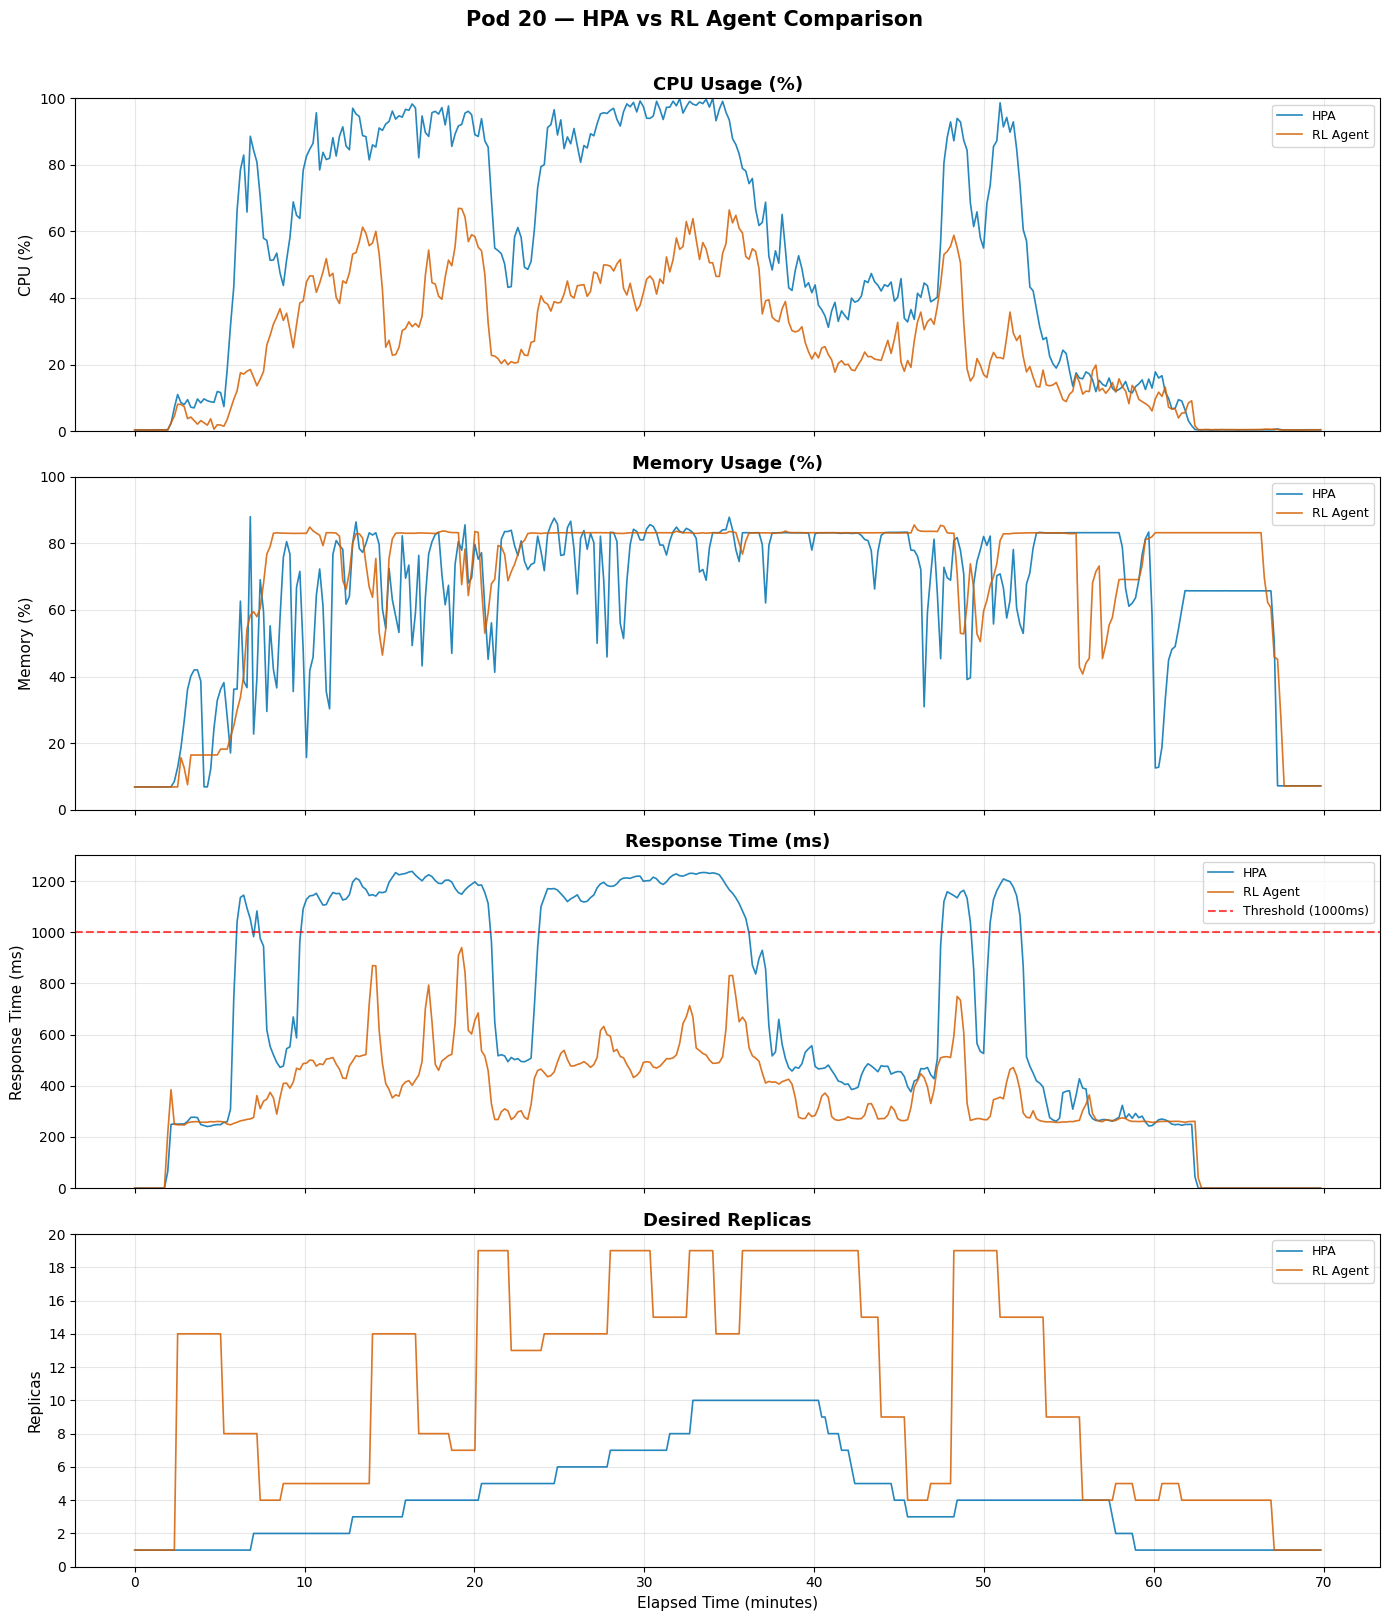

In [ ]:
import os

# Create chart folder for pod_20
os.makedirs("pod_20/chart", exist_ok=True)

DEPLOY_A = "hpa-flask-app"
DEPLOY_B = "test-flask-app"
COLORS = {DEPLOY_A: "#0072B2", DEPLOY_B: "#D55E00"}  # cyan / pink

datasets = [
    (df_cpu, "CPU Usage (%)", "CPU (%)", "testing_cpu_usage_20.png", 100, None),
    (df_mem, "Memory Usage (%)", "Memory (%)", "testing_memory_usage_20.png", 100, None),
    (df_rt, "Response Time (ms)", "Response Time (ms)", "testing_response_time_20.png", 1300, 1000),
    (df_rep, "Desired Replicas", "Replicas", "testing_replicas_20.png", 20, None),
]

# Save individual charts
for df, title, ylabel, filename, ylim, threshold in datasets:
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    for deploy in [DEPLOY_A, DEPLOY_B]:
        subset = df[df["deployment"] == deploy].sort_values("_elapsed_min")
        label = "HPA" if deploy == DEPLOY_A else "RL Agent"
        ax.plot(
            subset["_elapsed_min"],
            subset["_value"],
            label=label,
            color=COLORS[deploy],
            linewidth=1.5,
            alpha=0.85,
        )

    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel("Elapsed Time (minutes)", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_ylim(0, ylim)

    if "Replicas" in title:
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    if threshold:
        ax.axhline(y=threshold, color="red", linestyle="--", linewidth=1.5, alpha=0.7, label=f"Threshold ({threshold}ms)")

    ax.legend(loc="upper right", fontsize=10)
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    fig.savefig(f"pod_20/chart/{filename}", dpi=300, bbox_inches="tight")
    plt.close()

print("✓ All pod_20 charts saved to pod_20/chart/")

# Display combined view
fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

for ax, (df, title, ylabel, _, ylim, threshold) in zip(axes, datasets):
    for deploy in [DEPLOY_A, DEPLOY_B]:
        subset = df[df["deployment"] == deploy].sort_values("_elapsed_min")
        label = "HPA" if deploy == DEPLOY_A else "RL Agent"
        ax.plot(
            subset["_elapsed_min"],
            subset["_value"],
            label=label,
            color=COLORS[deploy],
            linewidth=1.2,
            alpha=0.85,
        )
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.set_ylim(0, ylim)
    if "Replicas" in title:
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    if threshold:
        ax.axhline(y=threshold, color="red", linestyle="--", linewidth=1.5, alpha=0.7, label=f"Threshold ({threshold}ms)")
    ax.legend(loc="upper right", fontsize=9)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Elapsed Time (minutes)", fontsize=11)
fig.suptitle(
    "Pod 20 — HPA vs RL Agent Comparison", fontsize=15, fontweight="bold", y=1.01
)
fig.tight_layout()
plt.show()

In [ ]:
# Load all pod_10 datasets
# 2026-02-07 00:28:33 | 2026-02-07 01:38:33 1 hour 10 minutes
# 2026-02-07 00:30:33 | 2026-02-07 01:30:33 1 hour
base = "pod_10"
df_cpu = load_influx_csv(f"{base}/cpu_10.csv")
df_mem = load_influx_csv(f"{base}/memori_10.csv")
df_rep = load_influx_csv(f"{base}/replika_10.csv")
df_rt  = load_influx_csv(f"{base}/waktu_respon_10.csv")

# Convert to relative time (elapsed minutes from start)
min_time = min(df_cpu["_time"].min(), df_mem["_time"].min(),
               df_rep["_time"].min(), df_rt["_time"].min())

for df in [df_cpu, df_mem, df_rep, df_rt]:
    df["_elapsed_min"] = (df["_time"] - min_time).dt.total_seconds() / 60

print(f"CPU  rows: {len(df_cpu)},  deployments: {df_cpu['deployment'].unique()}")
print(f"MEM  rows: {len(df_mem)},  deployments: {df_mem['deployment'].unique()}")
print(f"REP  rows: {len(df_rep)},  deployments: {df_rep['deployment'].unique()}")
print(f"RT   rows: {len(df_rt)},   deployments: {df_rt['deployment'].unique()}")

CPU  rows: 722,  deployments: ['hpa-flask-app' 'test-flask-app']
MEM  rows: 722,  deployments: ['hpa-flask-app' 'test-flask-app']
REP  rows: 722,  deployments: ['hpa-flask-app' 'test-flask-app']
RT   rows: 722,   deployments: ['hpa-flask-app' 'test-flask-app']


✓ All pod_10 charts saved to pod_10/chart/


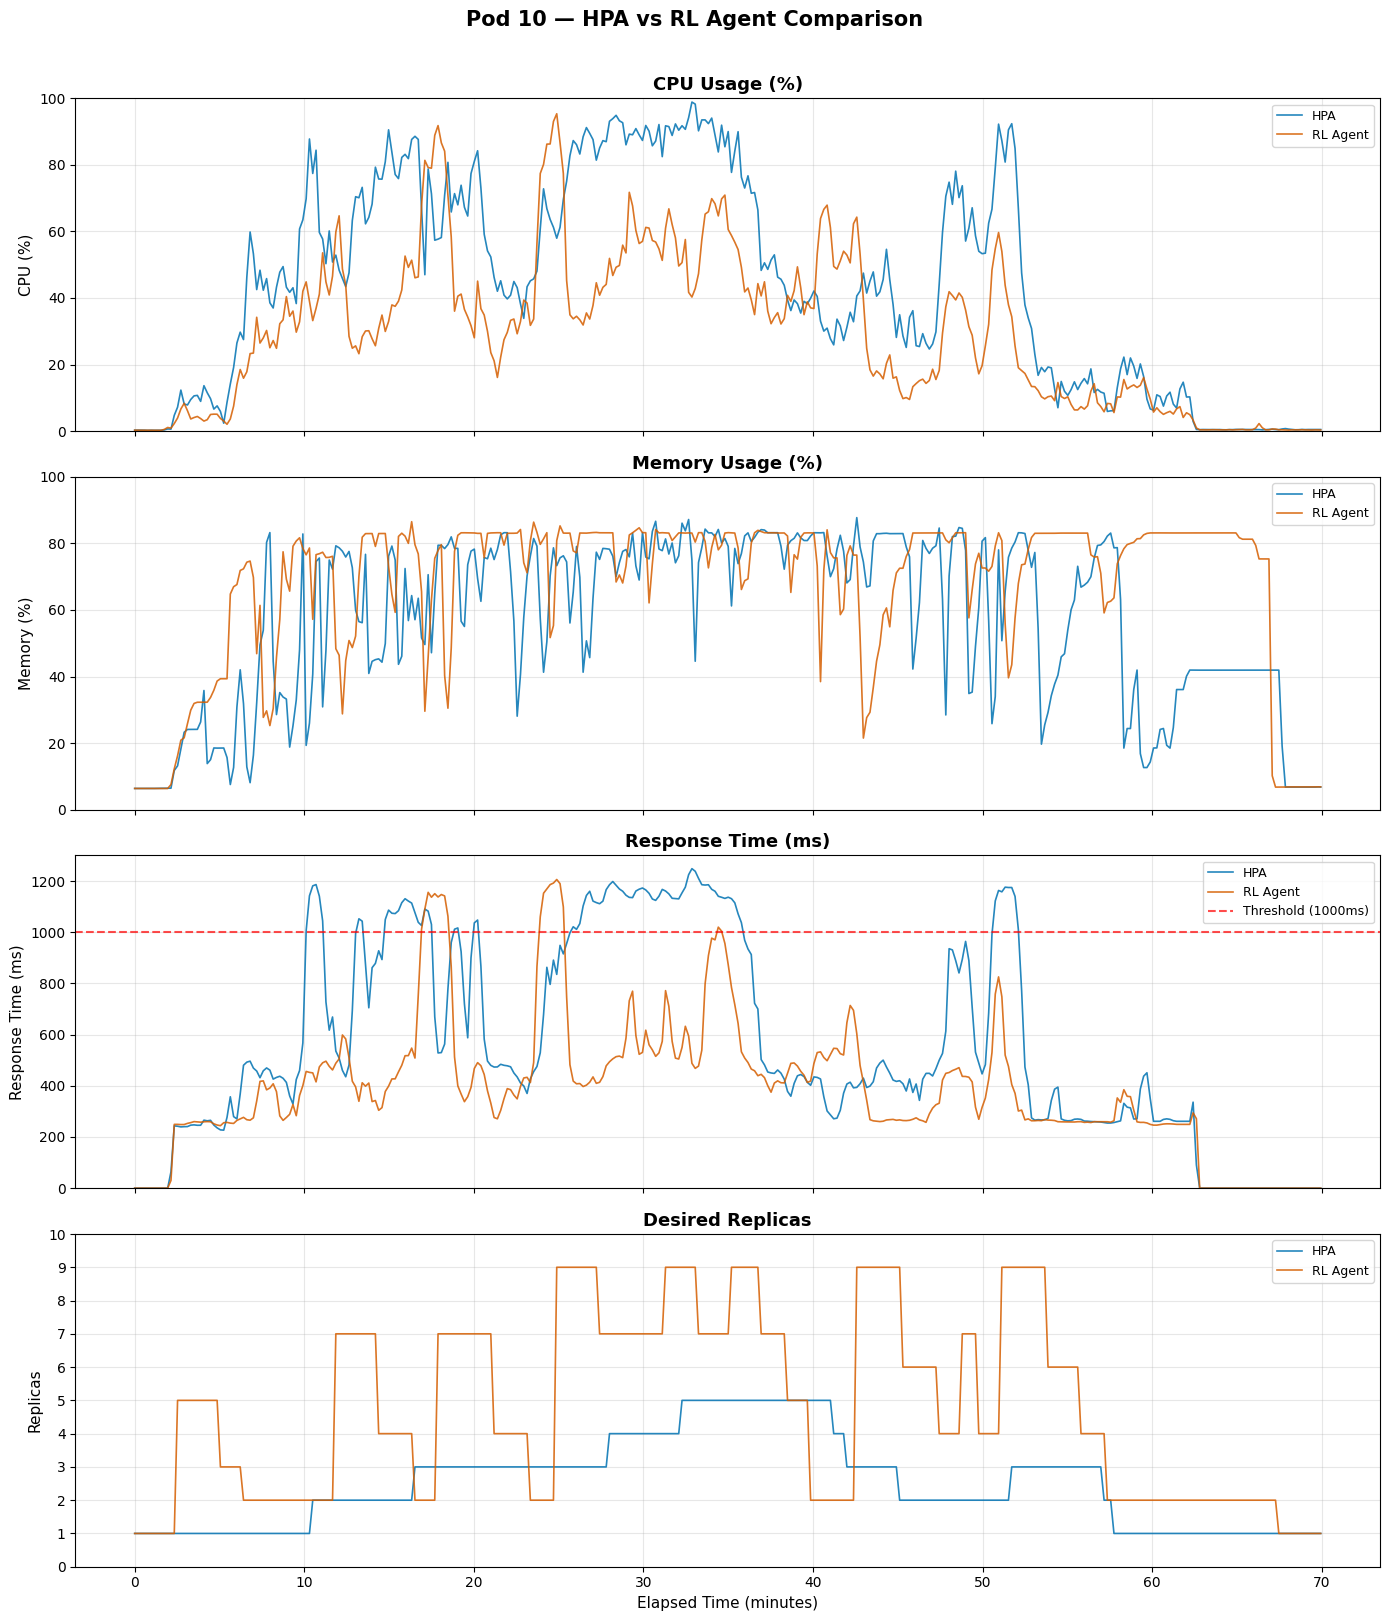

In [ ]:
# Create chart folder for pod_10
os.makedirs("pod_10/chart", exist_ok=True)

DEPLOY_A = "hpa-flask-app"
DEPLOY_B = "test-flask-app"
COLORS = {DEPLOY_A: "#0072B2", DEPLOY_B: "#D55E00"}  # cyan / pink

datasets = [
    (df_cpu, "CPU Usage (%)", "CPU (%)", "testing_cpu_usage_10.png", 100, None),
    (df_mem, "Memory Usage (%)", "Memory (%)", "testing_memory_usage_10.png", 100, None),
    (df_rt, "Response Time (ms)", "Response Time (ms)", "testing_response_time_10.png", 1300, 1000),
    (df_rep, "Desired Replicas", "Replicas", "testing_replicas_10.png", 10, None),
]

# Save individual charts
for df, title, ylabel, filename, ylim, threshold in datasets:
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    for deploy in [DEPLOY_A, DEPLOY_B]:
        subset = df[df["deployment"] == deploy].sort_values("_elapsed_min")
        label = "HPA" if deploy == DEPLOY_A else "RL Agent"
        ax.plot(
            subset["_elapsed_min"],
            subset["_value"],
            label=label,
            color=COLORS[deploy],
            linewidth=1.5,
            alpha=0.85,
        )

    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel("Elapsed Time (minutes)", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_ylim(0, ylim)

    if "Replicas" in title:
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    if threshold:
        ax.axhline(y=threshold, color="red", linestyle="--", linewidth=1.5, alpha=0.7, label=f"Threshold ({threshold}ms)")

    ax.legend(loc="upper right", fontsize=10)
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    fig.savefig(f"pod_10/chart/{filename}", dpi=300, bbox_inches="tight")
    plt.close()

print("✓ All pod_10 charts saved to pod_10/chart/")

# Display combined view
fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

for ax, (df, title, ylabel, _, ylim, threshold) in zip(axes, datasets):
    for deploy in [DEPLOY_A, DEPLOY_B]:
        subset = df[df["deployment"] == deploy].sort_values("_elapsed_min")
        label = "HPA" if deploy == DEPLOY_A else "RL Agent"
        ax.plot(
            subset["_elapsed_min"],
            subset["_value"],
            label=label,
            color=COLORS[deploy],
            linewidth=1.2,
            alpha=0.85,
        )
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.set_ylim(0, ylim)
    if "Replicas" in title:
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    if threshold:
        ax.axhline(y=threshold, color="red", linestyle="--", linewidth=1.5, alpha=0.7, label=f"Threshold ({threshold}ms)")
    ax.legend(loc="upper right", fontsize=9)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Elapsed Time (minutes)", fontsize=11)
fig.suptitle(
    "Pod 10 — HPA vs RL Agent Comparison", fontsize=15, fontweight="bold", y=1.01
)
fig.tight_layout()
plt.show()
